In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 12)

In [77]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.head()

DATE   Sales
0 2001-01-01  6519.0
1 2001-02-01  6654.0
2 2001-03-01  7332.0
3 2001-04-01  7332.0
4 2001-05-01  8240.0

In [78]:
mobile_sales.dtypes

DATE     datetime64[ns]
Sales           float64
dtype: object

In [79]:
mobile_sales.Sales.describe()

count      198.000000
mean     10842.757576
std       2605.006293
min        108.000000
25%       8856.000000
50%      10745.000000
75%      12399.750000
max      23740.000000
Name: Sales, dtype: float64

In [80]:
mobile_sales.describe()

Sales
count    198.000000
mean   10842.757576
std     2605.006293
min      108.000000
25%     8856.000000
50%    10745.000000
75%    12399.750000
max    23740.000000

In [81]:
##Check if dates are missing
# Jan 2001 -jan 2019 (18 years 1 month == 217 month)

In [82]:
mobile_sales.set_index('DATE',inplace=True)

In [83]:
mobile_sales.head()

Sales
DATE              
2001-01-01  6519.0
2001-02-01  6654.0
2001-03-01  7332.0
2001-04-01  7332.0
2001-05-01  8240.0

<AxesSubplot:xlabel='DATE'>

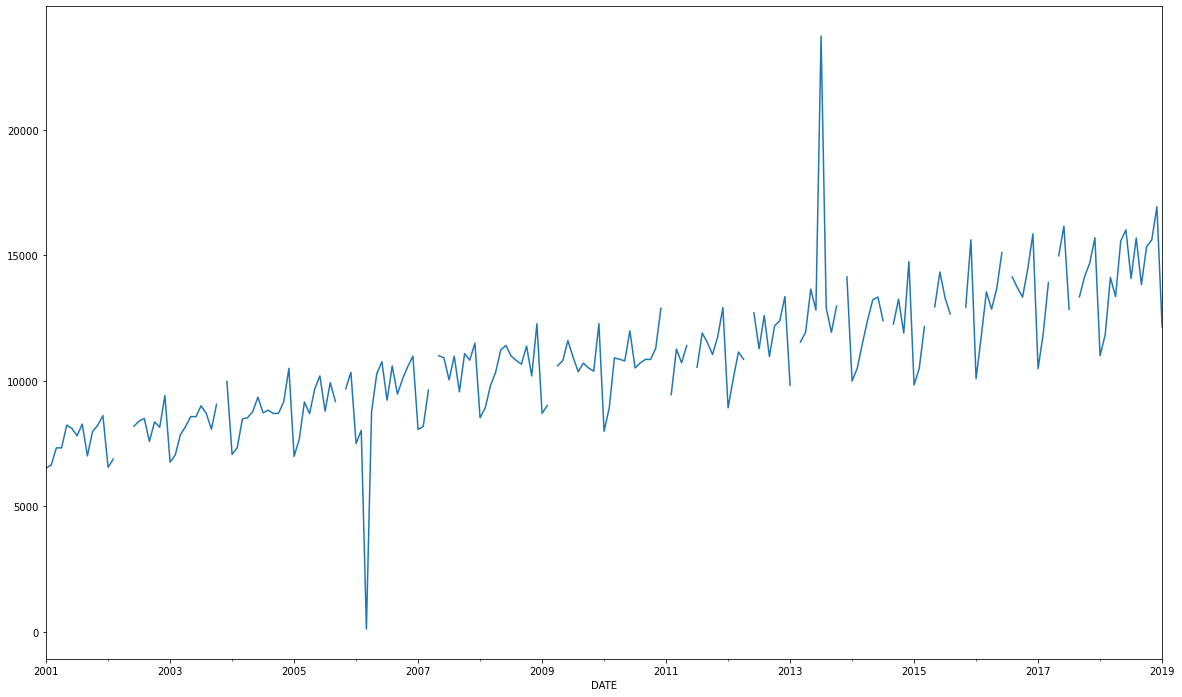

In [84]:
mobile_sales.Sales.plot()

### Handeling Missing Values

<AxesSubplot:xlabel='DATE'>

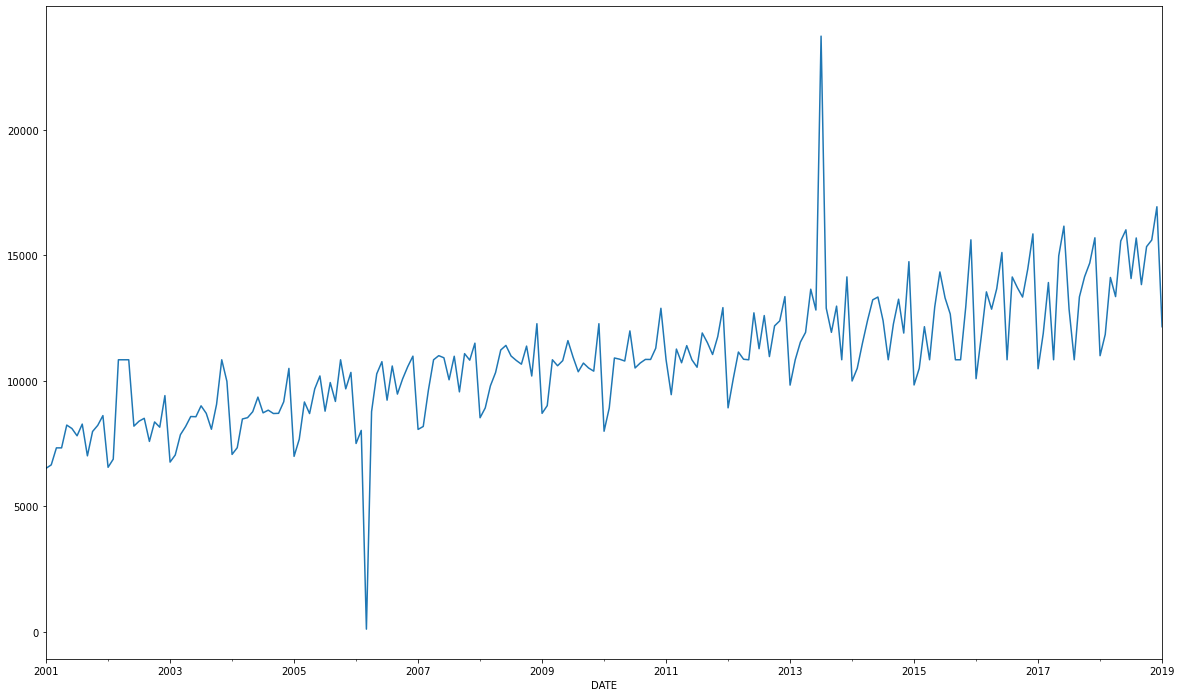

In [85]:
##filling NA with mean of entire data
mobile_sales.Sales.fillna(mobile_sales.Sales.mean()).plot(label="imputed")

<AxesSubplot:xlabel='DATE'>

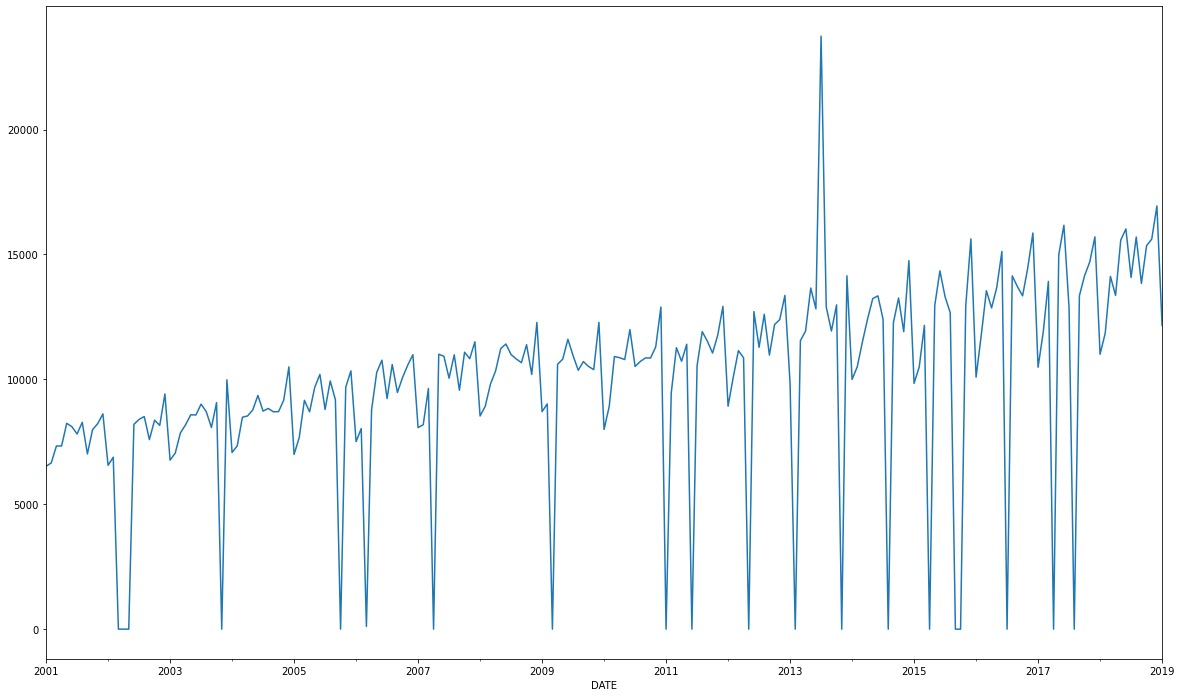

In [86]:
##filling NA with 0
mobile_sales.Sales.fillna(0).plot(label="imputed")

### Liner Interpolation

<AxesSubplot:xlabel='DATE'>

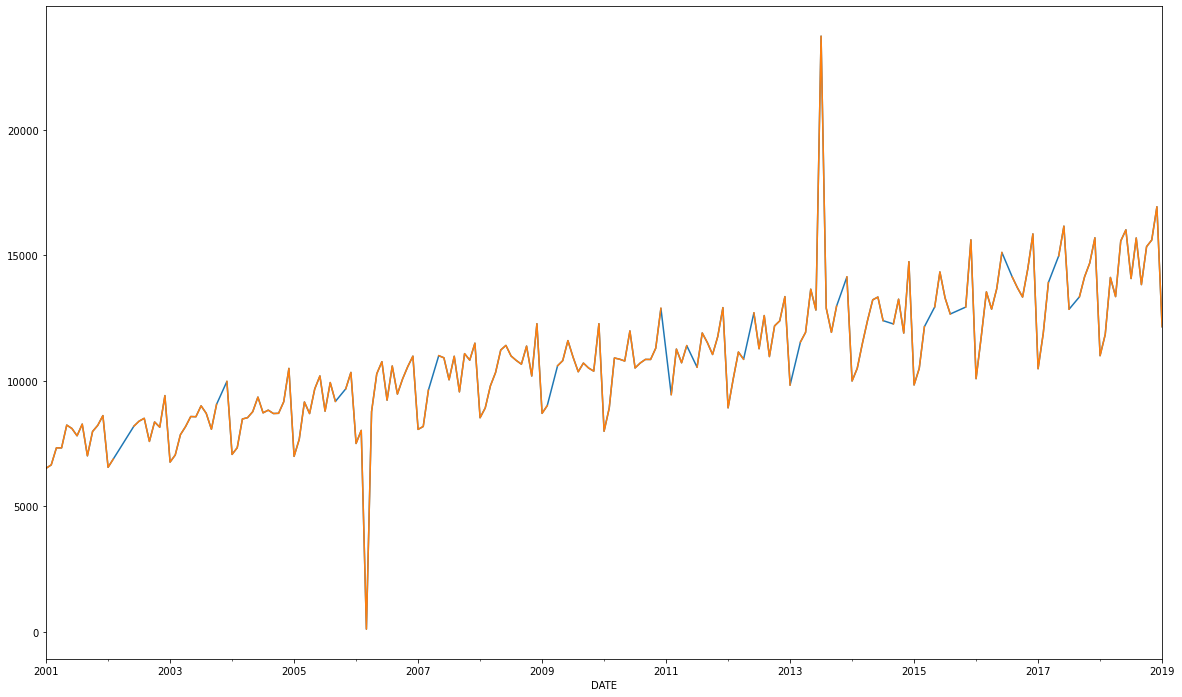

In [87]:
mobile_sales.Sales.interpolate(method="linear").plot(label='imputed linear int')
mobile_sales.Sales.plot(label='original')

In [88]:
mobile_sales.Sales=mobile_sales.Sales.interpolate(method="linear")

## Identifying and Removing Outliers

[]

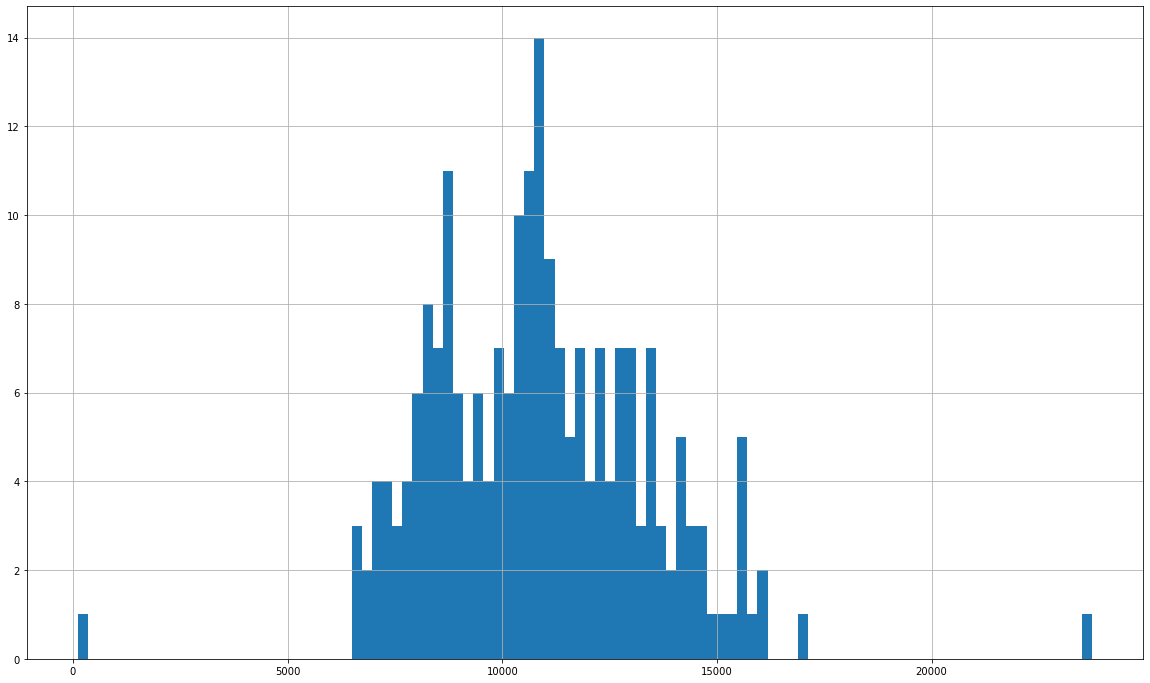

In [89]:

mobile_sales.Sales.hist(bins=100).plot()

In [90]:
mobile_sales.Sales.quantile(0.99)

16144.480000000001

In [91]:
mobile_sales.Sales.quantile(0.005)

6522.12

In [92]:
mobile_sales.Sales=mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.99),lower=mobile_sales.Sales.quantile(0.005))

<AxesSubplot:xlabel='DATE'>

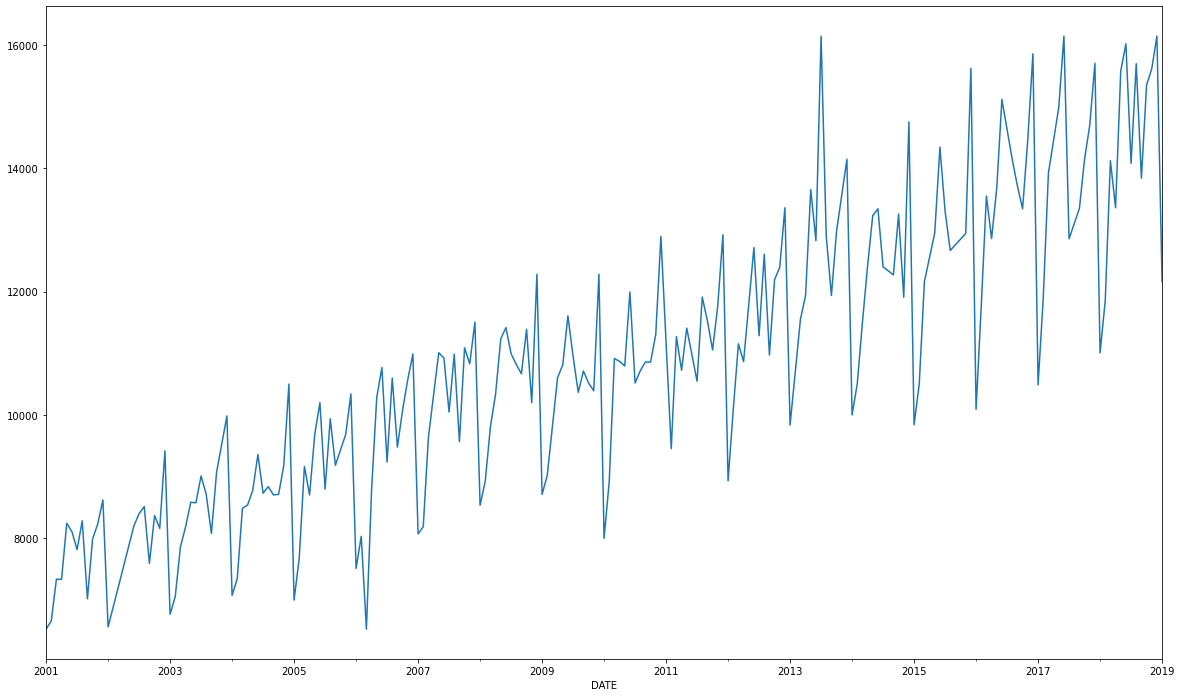

In [93]:
mobile_sales.Sales.plot()

### Moving Averages

<AxesSubplot:xlabel='DATE'>

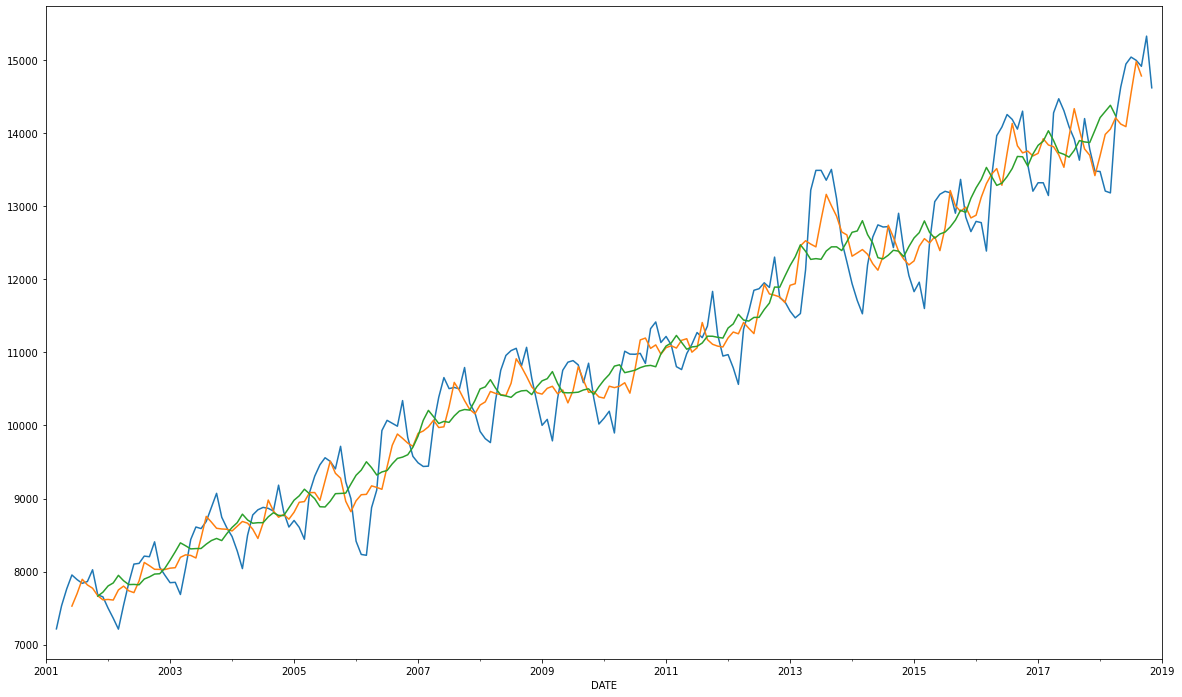

In [94]:

# mobile_sales.Sales.plot(style='-o')
mobile_sales.Sales.rolling(5,center=True).mean().plot(label="5")
mobile_sales.Sales.rolling(10,center=True).mean().plot(label="10")
mobile_sales.Sales.rolling(20,center=True).mean().plot(label="20")

<AxesSubplot:xlabel='DATE'>

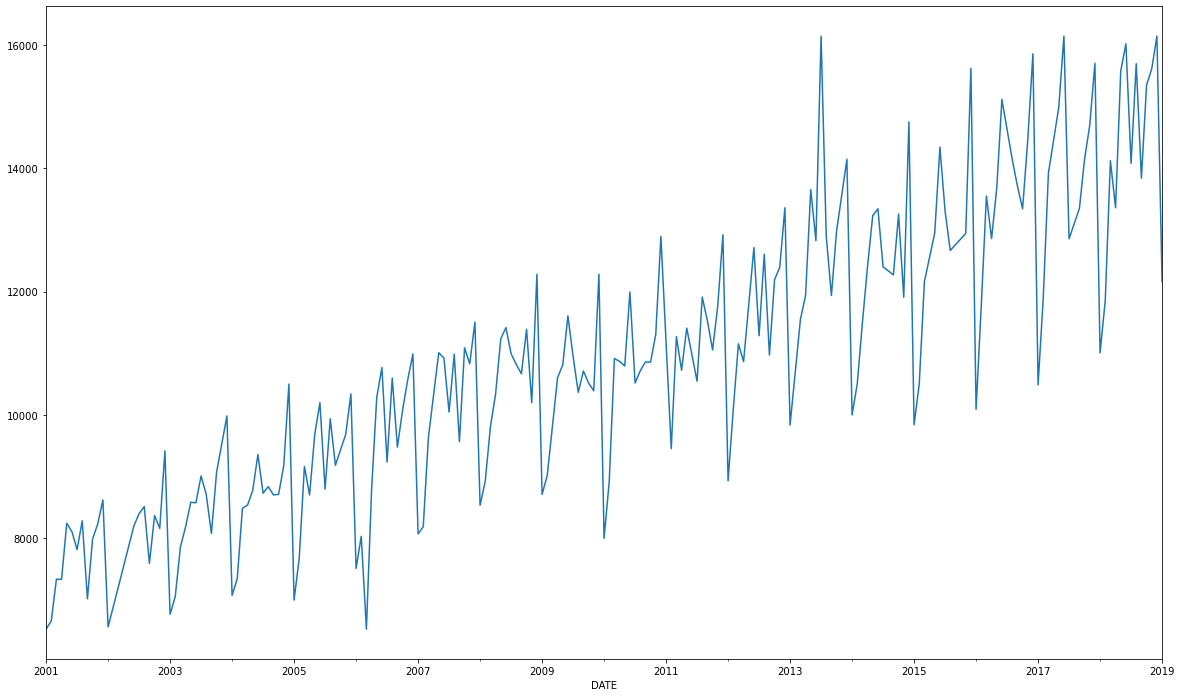

In [95]:
mobile_sales.Sales.plot(label="5")

###  TS decompositon 

In [96]:
import statsmodels.api as sm

In [97]:
model=sm.tsa.seasonal_decompose(mobile_sales.Sales,model='additive')

In [98]:
plt.rcParams['figure.figsize'] = (20, 10)

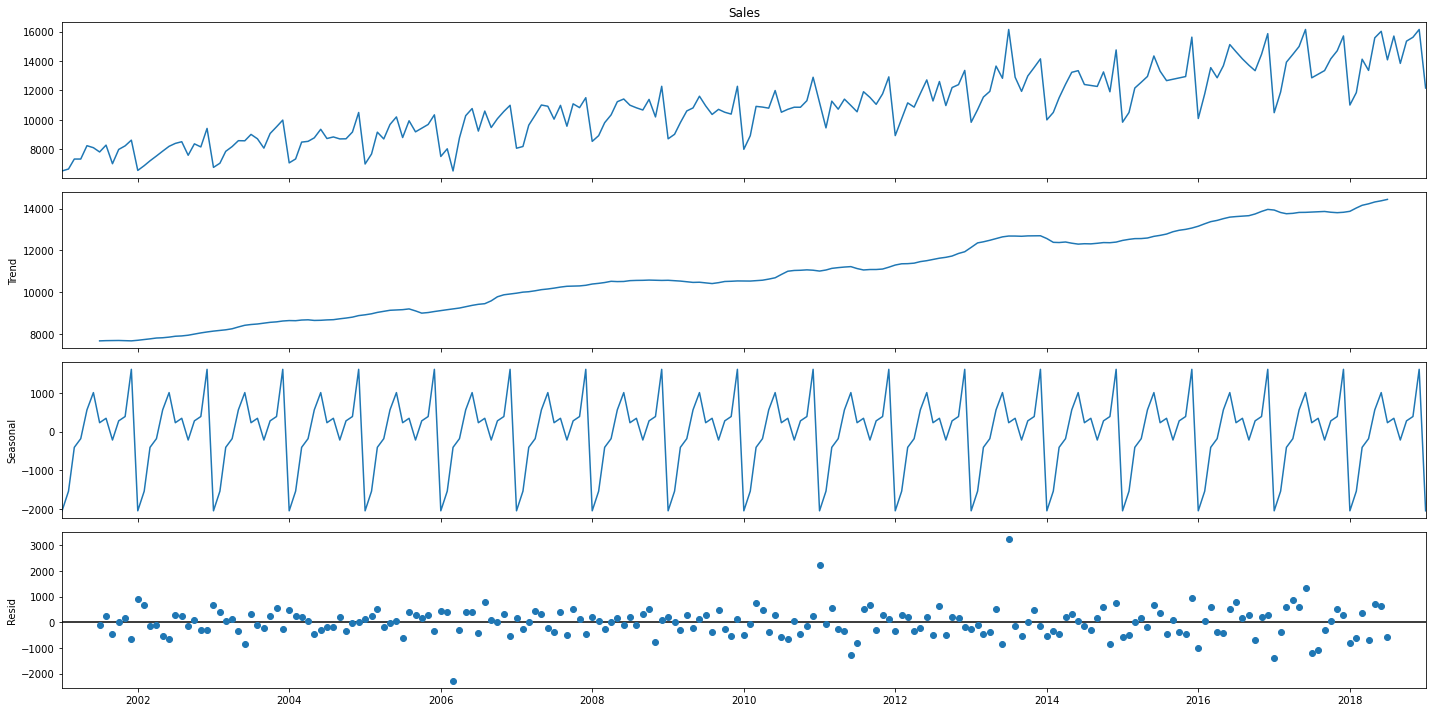

In [99]:
model.plot();

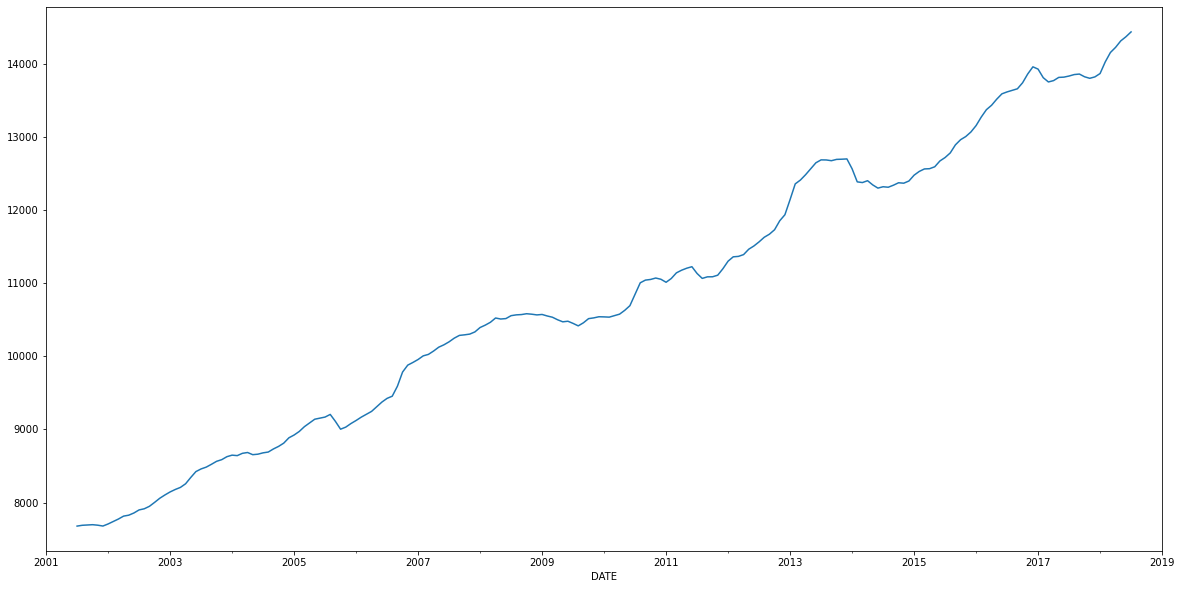

In [100]:
model.trend.plot();

#### See how increasing the window straighten the final MA

<AxesSubplot:xlabel='DATE'>

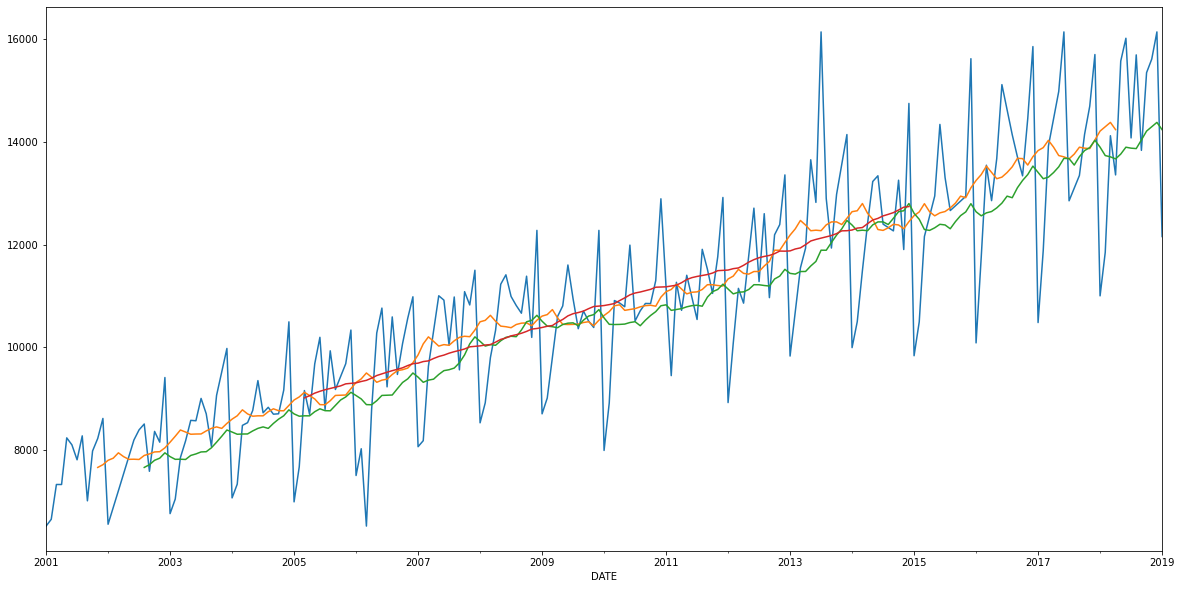

In [101]:
mobile_sales.Sales.plot(label="original")
# mobile_sales.Sales.rolling(5,center=True).mean().plot(label="5 MA")
# mobile_sales.Sales.rolling(10,center=True).mean().plot(label="10 MA")
mobile_sales.Sales.rolling(20,center=True).mean().plot(label="20 MA")
mobile_sales.Sales.rolling(20,center=False).mean().plot(label="20 MA One sided")
mobile_sales.Sales.rolling(100,center=True).mean().plot(label="100 MA")

#### Compare 12 MA with Decomposed Trend

<AxesSubplot:xlabel='DATE'>

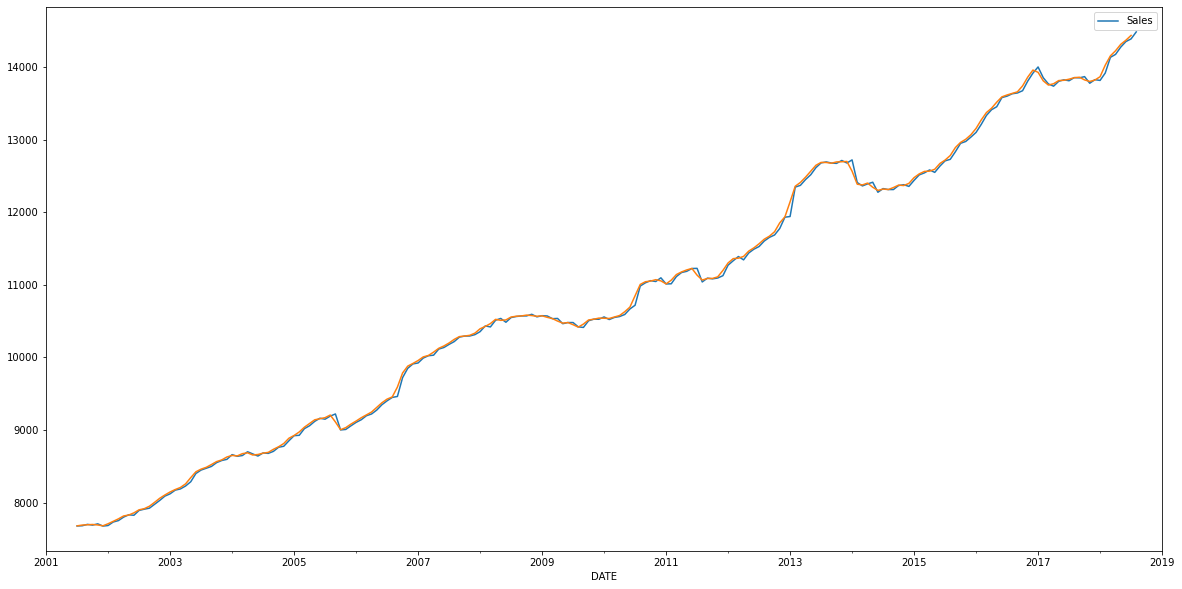

In [102]:
trend = mobile_sales.rolling(12, center=True).mean()
trend.plot()
model.trend.plot()

##### Remove Approx Trend From mobile sales
We get data without approx trend (this is mostly the Seasonality)
<br>PS: If you want to see the data in trend or detrend use head(15) as initial values would be null

<AxesSubplot:xlabel='DATE'>

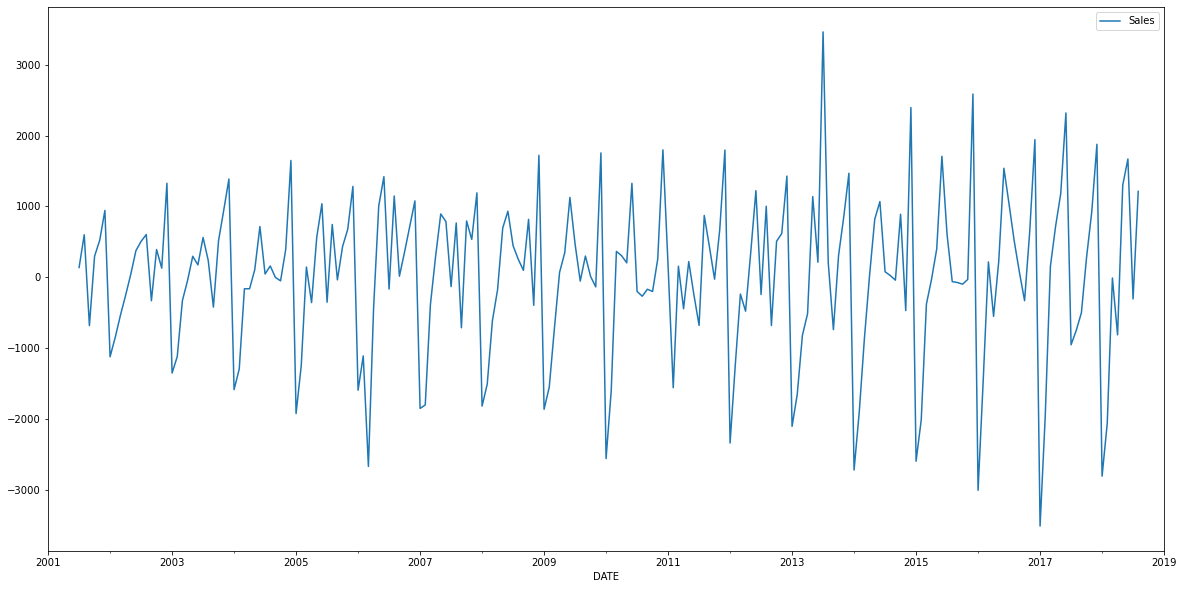

In [103]:
detrend=mobile_sales-trend
detrend.plot()

<AxesSubplot:xlabel='DATE'>

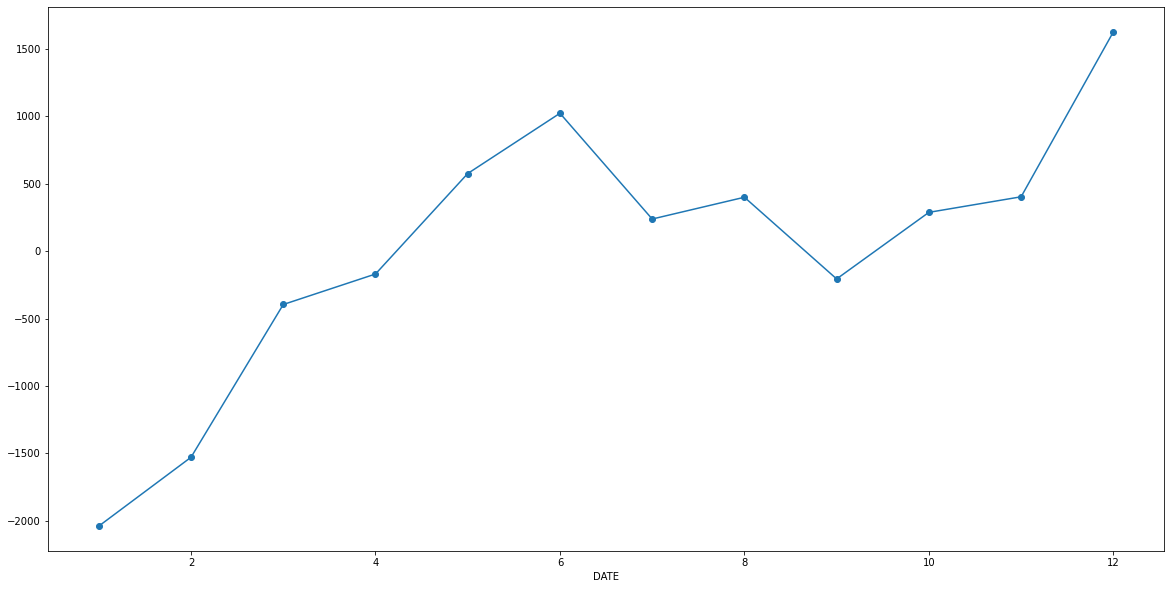

In [104]:
##Find Avg Seasonality for Every Month
dtf = detrend.reset_index()
dtf.groupby(dtf.DATE.dt.month)['Sales'].mean().plot(style='-o')

<AxesSubplot:xlabel='DATE'>

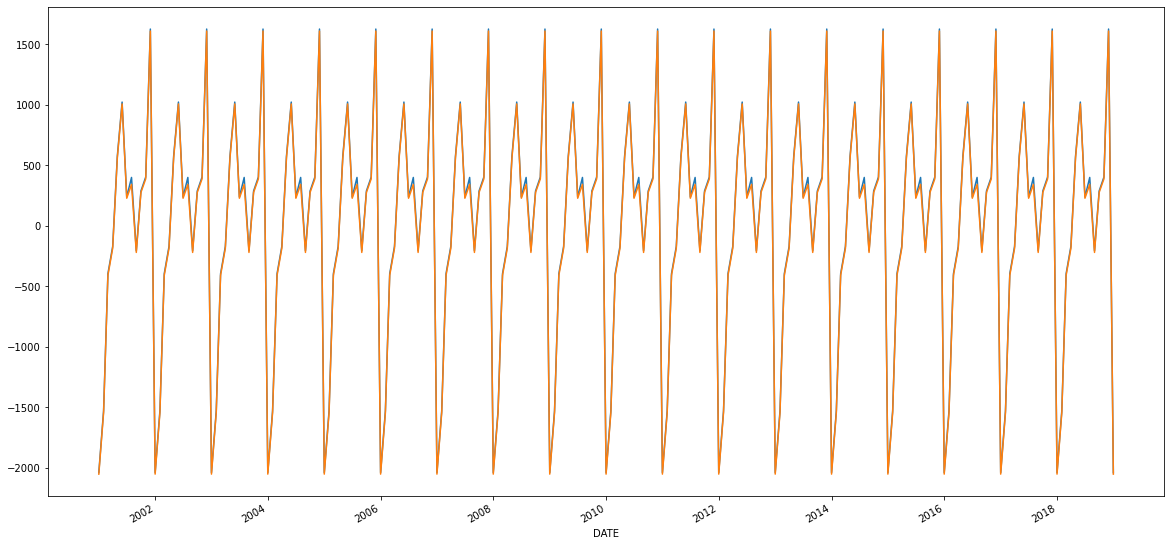

In [105]:
## Compare Model Seasonality decompose with Avg Seasonality
plt.plot(dtf.DATE, dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean'))
model.seasonal.plot()

### Simple Forecasting Methods

In [106]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

In [107]:
### How do you measure accuracy/performance

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))


### Naive Approach

MAE : 3479.79
RMSE : 3757.483
MAPE: 0.232


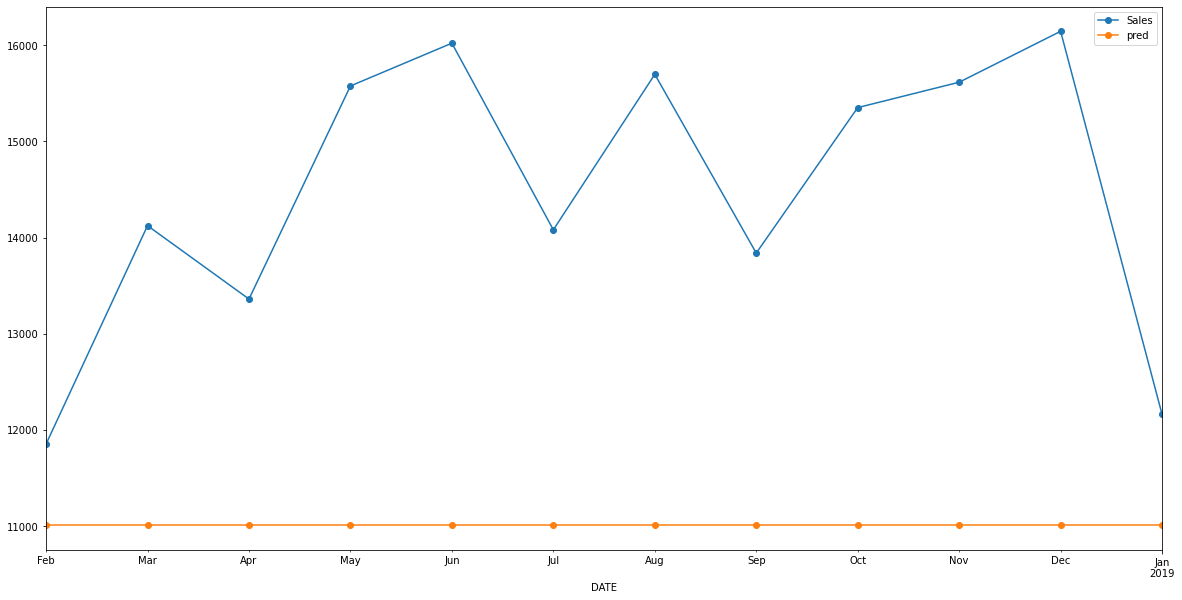

In [108]:
test_x['pred']=train_x['Sales'][-1]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Mean Approach

MAE : 3832.911
RMSE : 4086.679
MAPE: 0.257


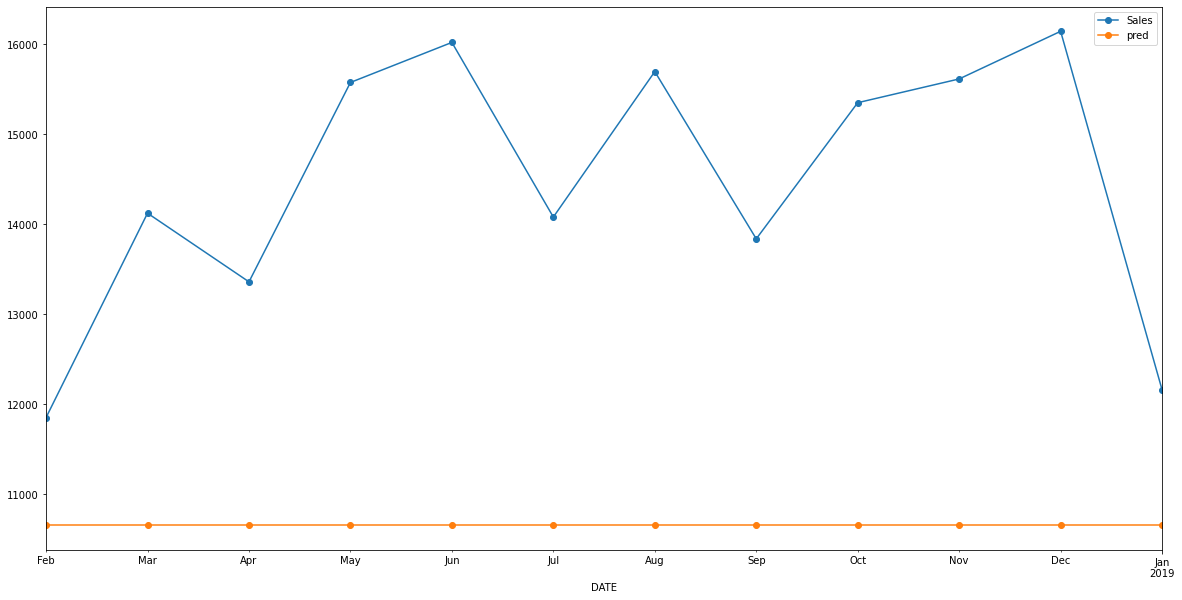

In [109]:
test_x['pred']=train_x['Sales'].mean()
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Seasonal Naive

In [110]:
test_x.index

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

MAE : 839.08
RMSE : 1075.542
MAPE: 0.058


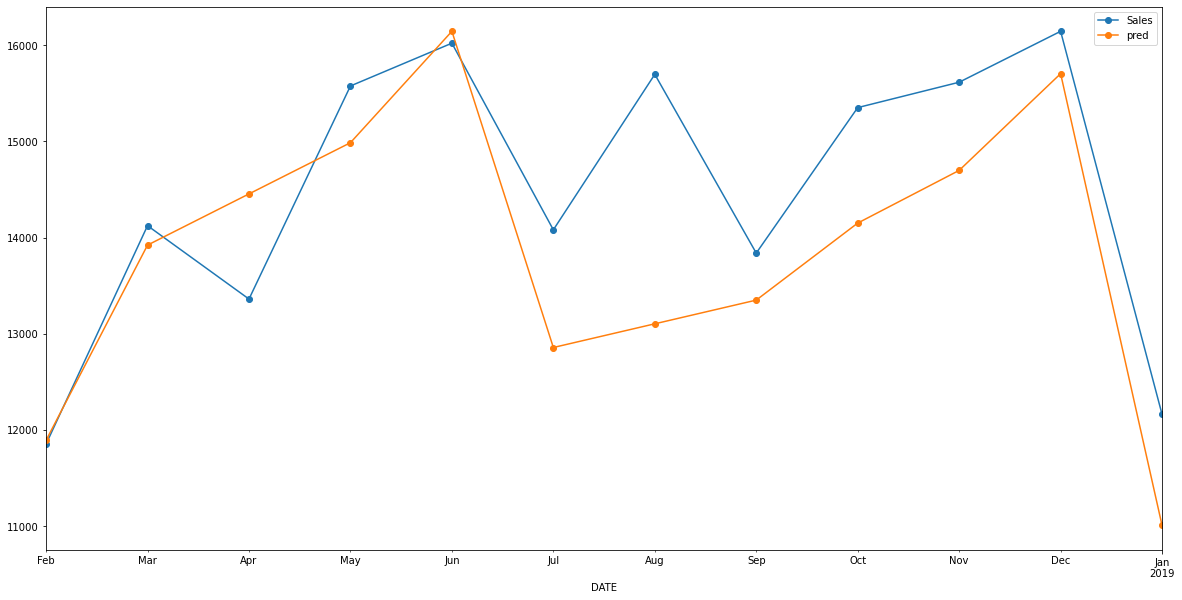

In [111]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

for i in test_x.index:
    test_x.loc[i,'pred'] = train_x.loc[(i - pd.DateOffset(years=1))]['Sales']

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Moving Average
We cant directly use the rolling function as it will give null values if just used on Training Data
<br> If you use all data (Mobile_Sales) then the output would be incorrect as we will then be using test data for training the model

In [112]:
### We need to create a new variable to store MA.
pred_ = train_x.Sales.copy().values
for i in range(12):
    pred_ = np.append(pred_, pred_[-3:].mean())
pd.Series(pred_)

0       6522.120000
1       6654.000000
2       7332.000000
3       7332.000000
4       8240.000000
           ...     
212    13184.042219
213    13175.059036
214    13195.613236
215    13184.904830
216    13185.192368
Length: 217, dtype: float64

MAE : 1738.024
RMSE : 1940.885
MAPE: 0.117


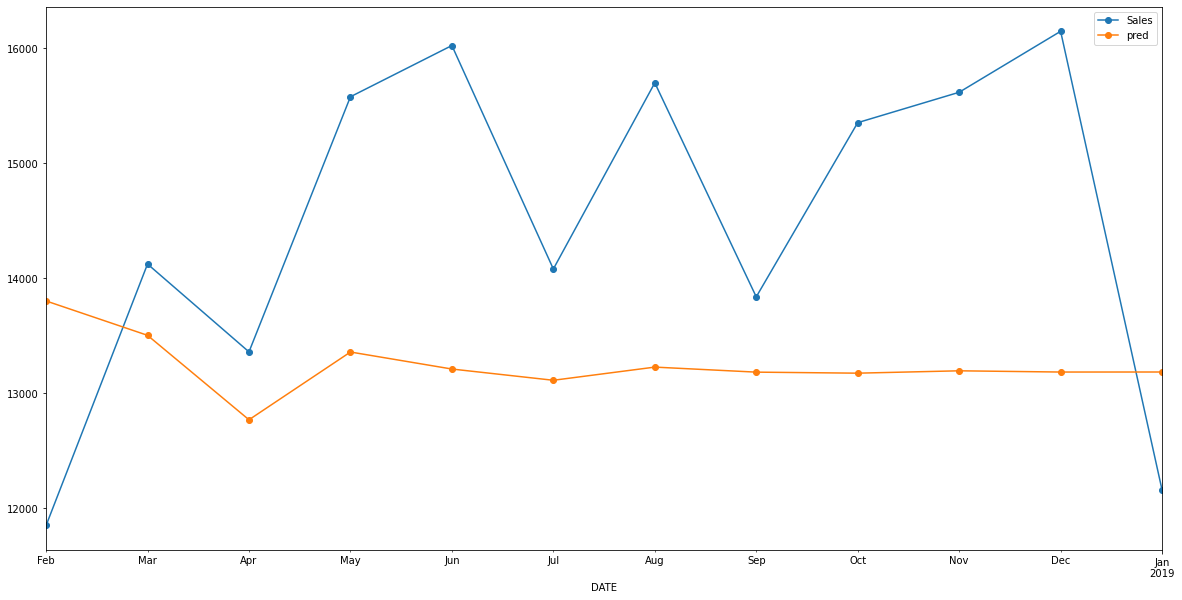

In [113]:
## take last 12 rows of the pred_ to find the predictions
test_x['pred'] = pred_[-12:]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Drift method

In [114]:
y_t=train_x['Sales'][-1]
y_0=train_x['Sales'][0]
slope= (y_t-y_0)/len(train_x['Sales'])
### Calculate the predicted values
for i in range(12):
    test_x.iloc[i]['pred']=slope*i + y_t

/var/folders/wc/7x5cjj6171gf3kyxlyncxf_c0000gn/T/ipykernel_98745/965450845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x.iloc[i]['pred']=slope*i + y_t


MAE : 1738.024
RMSE : 1940.885
MAPE: 0.117


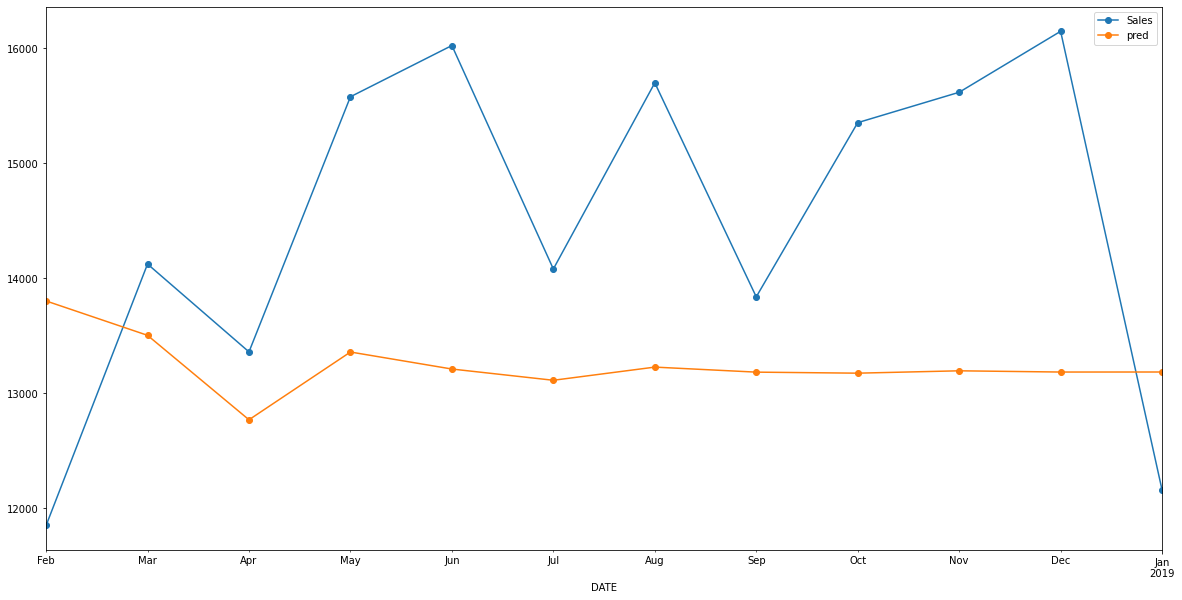

In [115]:
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Smoothing Approaches
Will be recovered in the upcoming classes


#### SES

In [116]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales)
_ = model.fit(smoothing_level = 0.8)
_.fittedvalues

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


DATE
2001-01-01     6522.120000
2001-02-01     6522.120000
2001-03-01     6627.624000
2001-04-01     7191.124800
2001-05-01     7303.824960
                  ...     
2018-09-01    15444.233816
2018-10-01    14159.246763
2018-11-01    15112.649353
2018-12-01    15514.529871
2019-01-01    16018.489974
Length: 217, dtype: float64

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


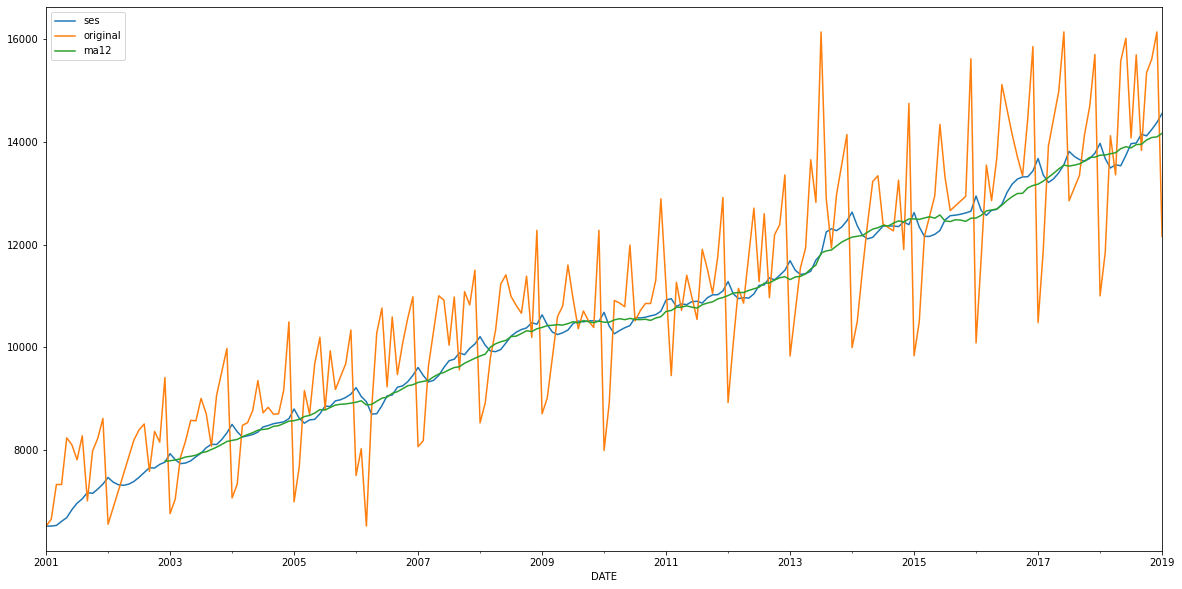

In [117]:
pred = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=0.1).fittedvalues)
pred.plot(label='ses')
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(24).mean().plot(label='ma12')
plt.legend()

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


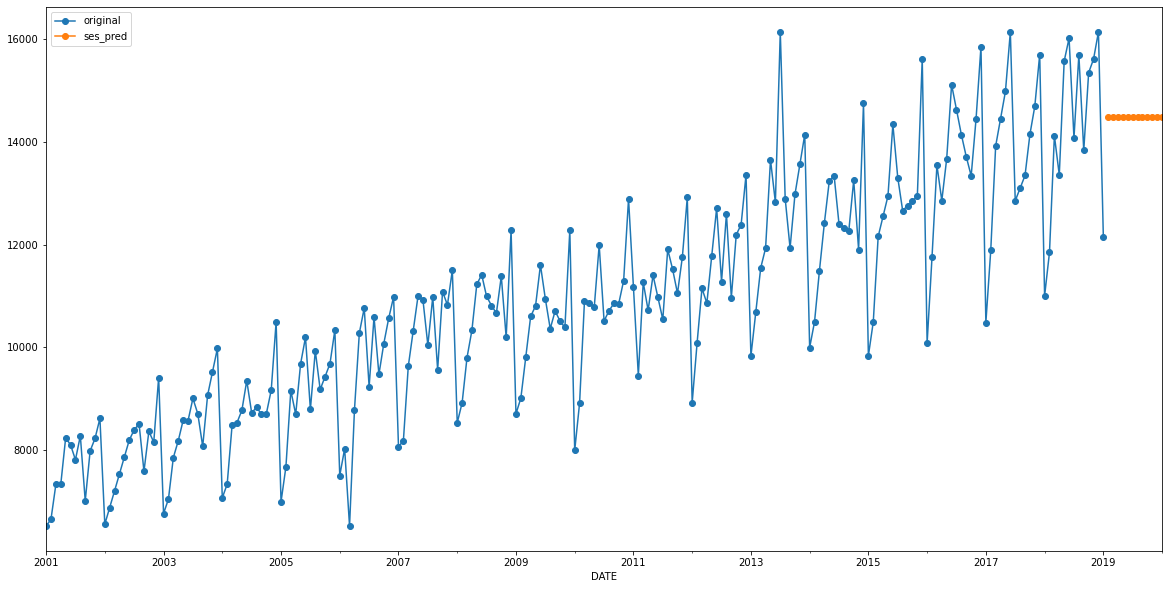

In [118]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=0.2)
pred = model.forecast(12)

mobile_sales.Sales.plot(label='original', style='-o')
pred.plot(label='ses_pred', style='-o')

plt.legend()

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


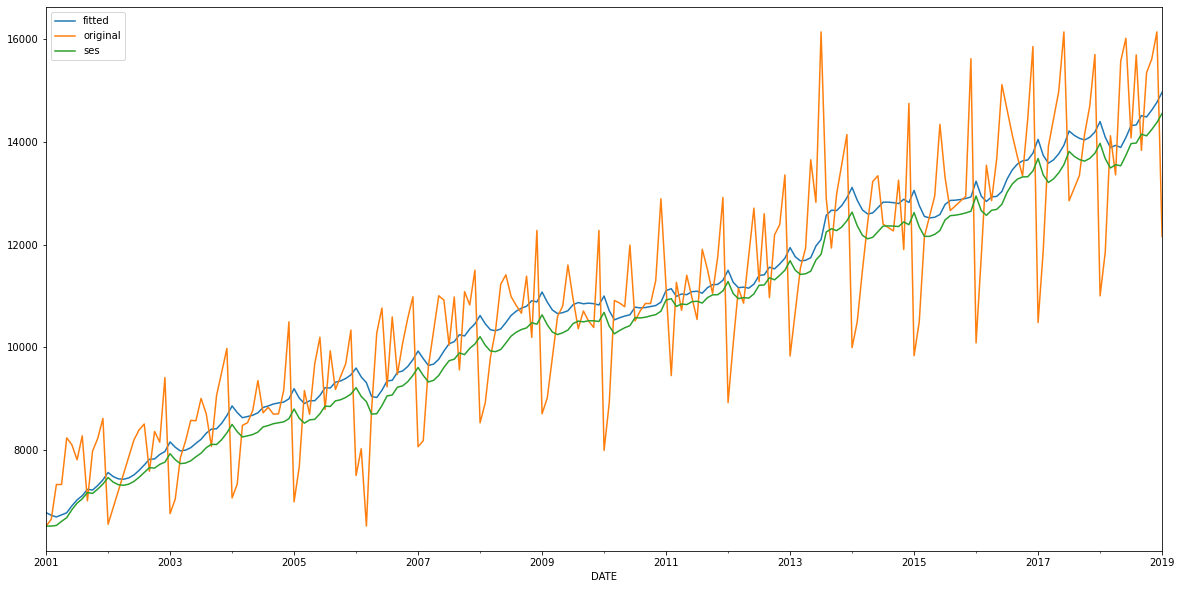

In [119]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add').fit()
model.fittedvalues.plot(label='fitted')
mobile_sales.Sales.plot(label='original')
pred1 = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=0.1).fittedvalues)
pred1.plot(label='ses')
plt.legend()

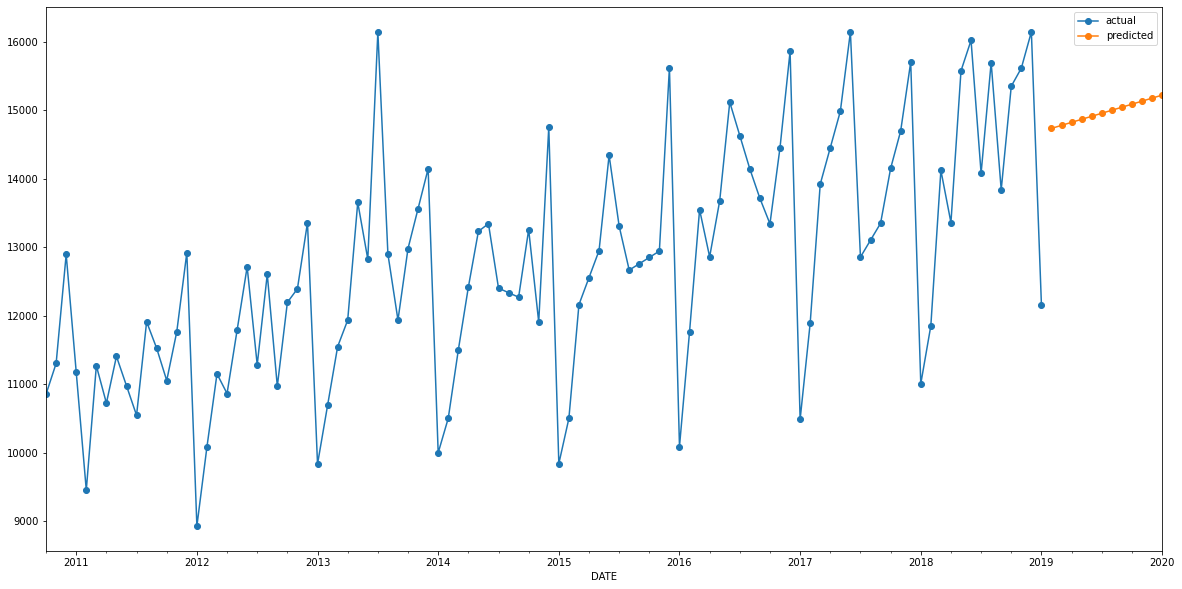

In [120]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

### TES

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


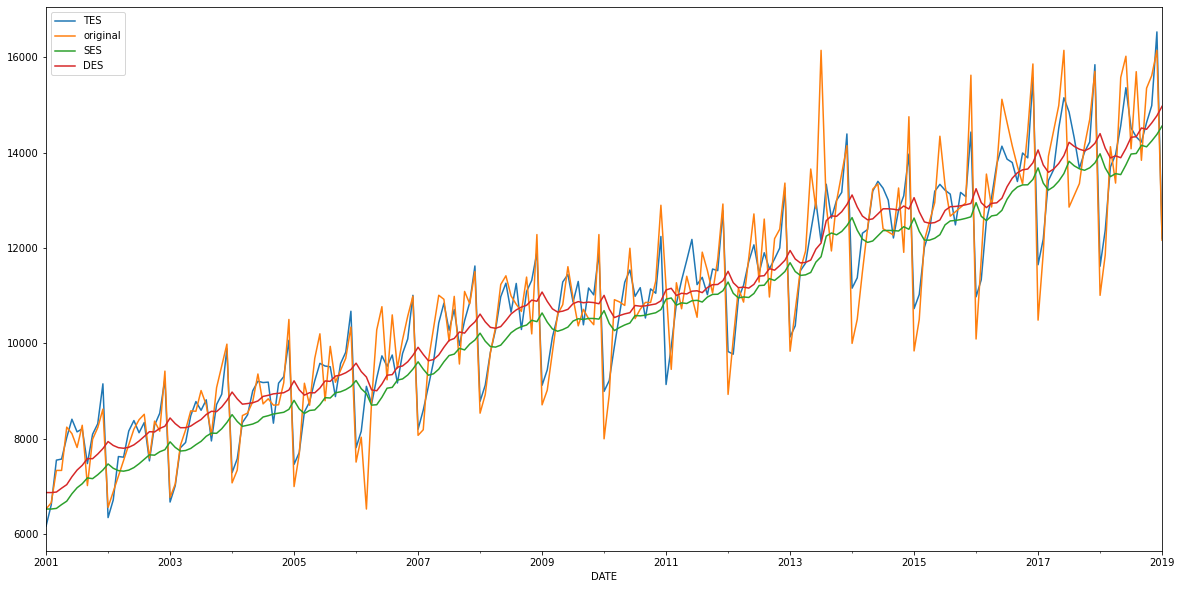

In [121]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add',seasonal='add').fit()
model.fittedvalues.plot(label='TES')
mobile_sales.Sales.plot(label='original')
pred1 = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=0.1).fittedvalues)
pred1.plot(label='SES')

pred2 = pd.Series(sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add').fit(smoothing_level=0.1).fittedvalues)
pred2.plot(label='DES')

plt.legend()

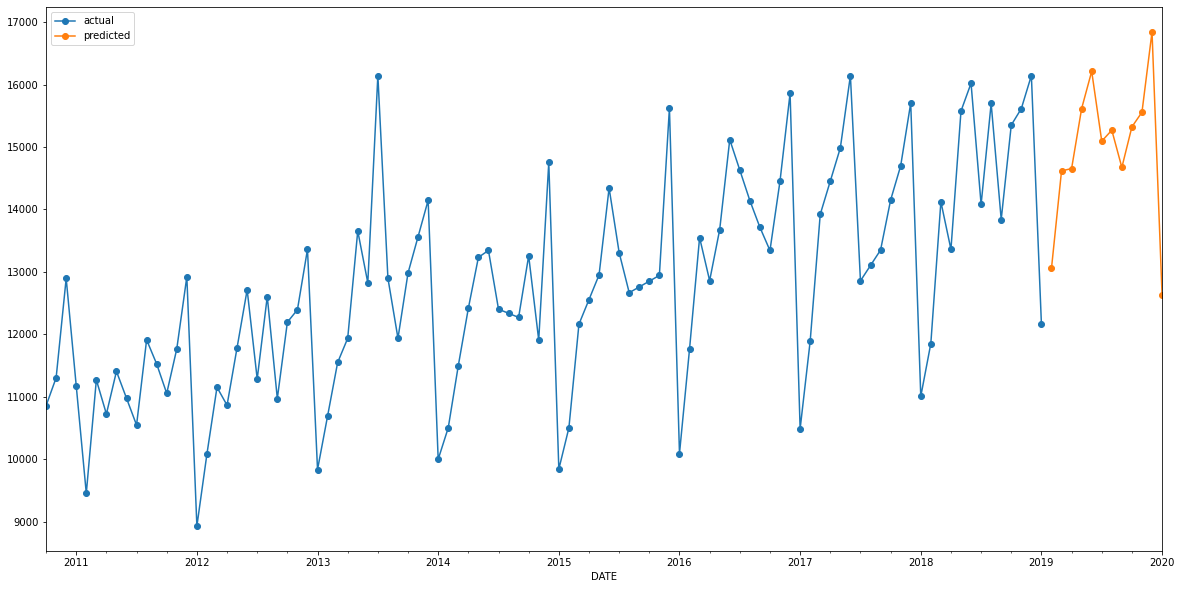

In [122]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

MAE : 515.549
RMSE : 549.724
MAPE: 0.035


/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


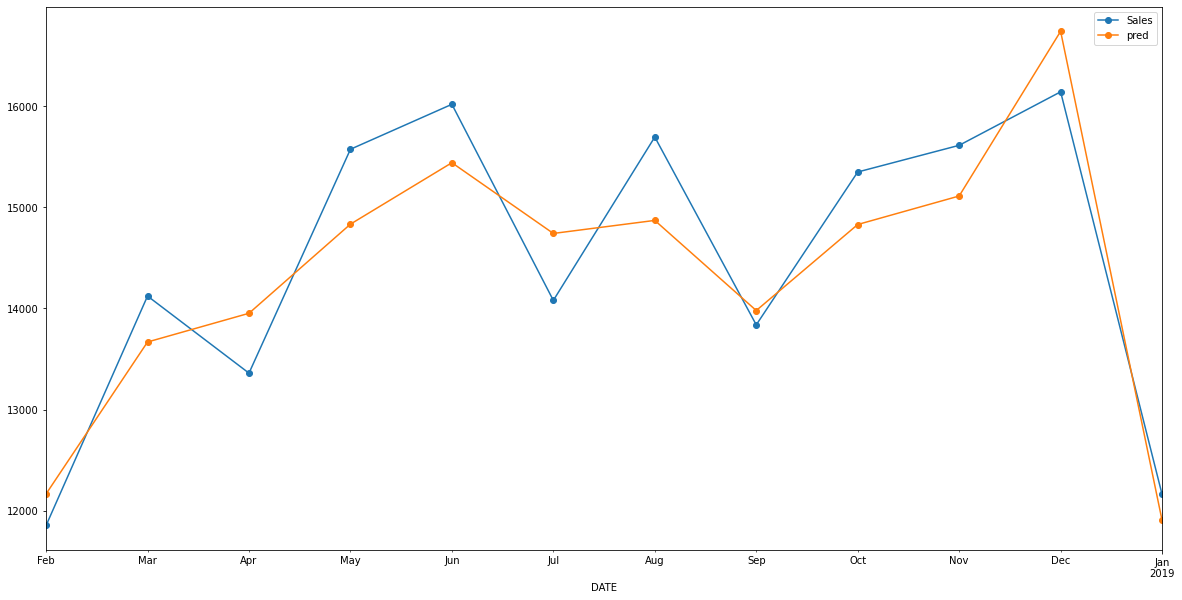

In [123]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='mul').fit(smoothing_level=1/24,smoothing_trend=0.2)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Dickey Fuller Test

In [124]:
sm.tsa.stattools.adfuller(mobile_sales.Sales)[1]

def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1] 
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')



In [125]:
adf_test(mobile_sales.Sales)

Sequence is not stationary


In [126]:
import statsmodels.api as sm
model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive')

In [127]:
adf_test(model.resid.dropna())

Sequence is stationary


<AxesSubplot:xlabel='DATE'>

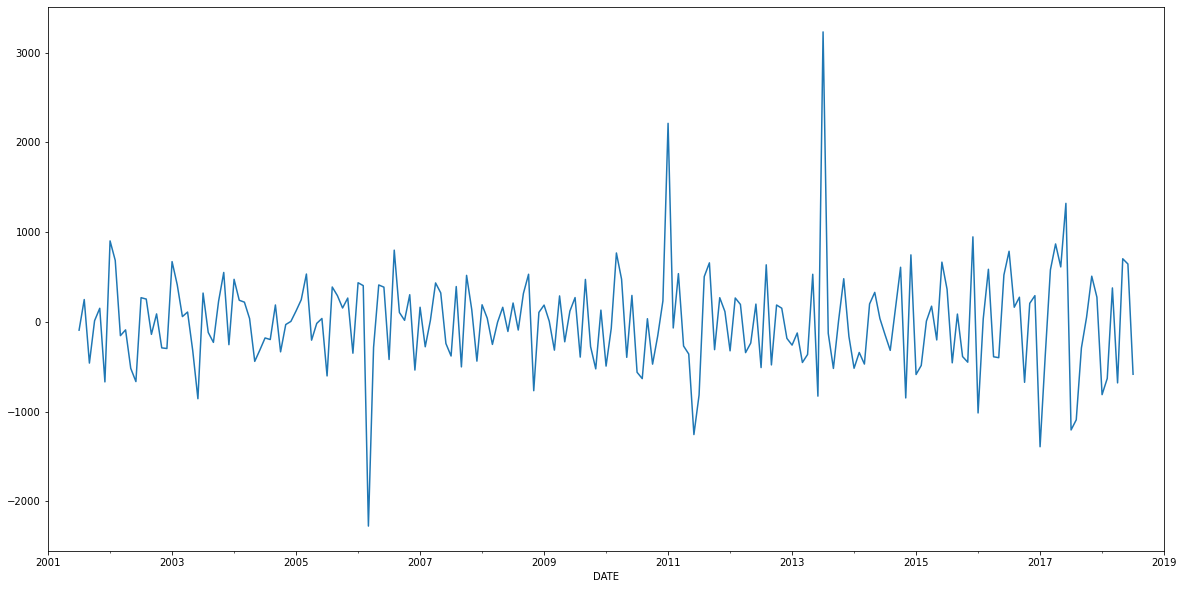

In [128]:
model.resid.plot()

<AxesSubplot:xlabel='DATE'>

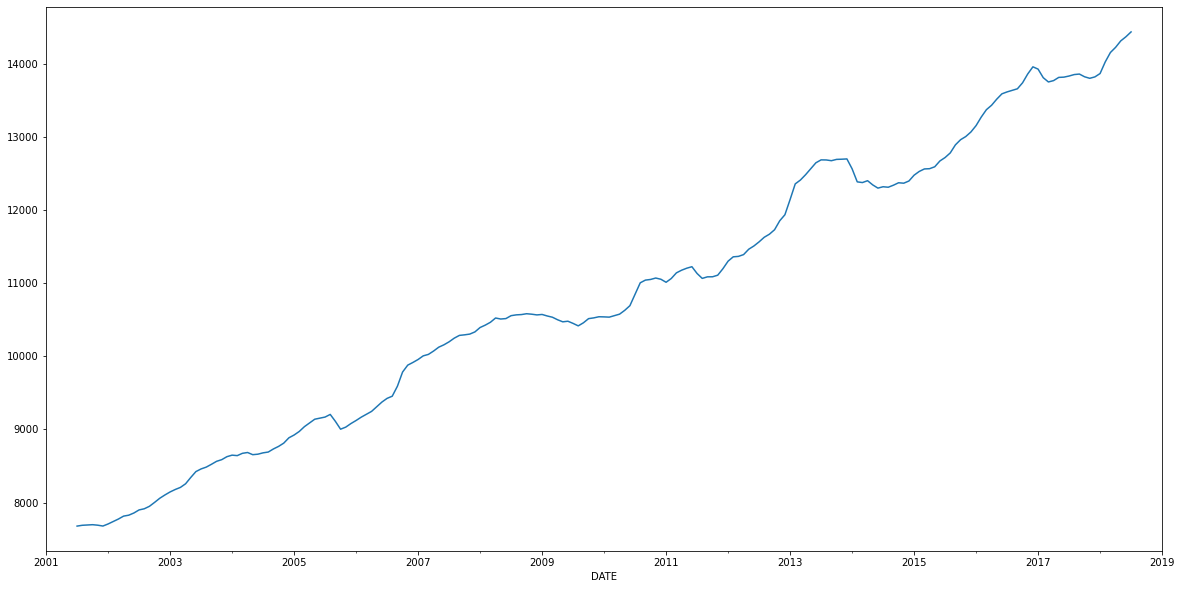

In [129]:
model.trend.plot()

In [130]:
## detrending

adf_test(mobile_sales.Sales.diff().dropna())

Sequence is stationary


In [131]:
## deseasonalisation

adf_test(mobile_sales.Sales.diff(12).dropna())

Sequence is stationary


In [132]:
## deseasonalisation and detrending

adf_test(mobile_sales.Sales.diff(12).diff().dropna())

Sequence is stationary


### Autocorrelation

In [133]:
np.corrcoef(mobile_sales.Sales[1:], mobile_sales.Sales.shift(1).dropna())

array([[1.        , 0.79742808],
       [0.79742808, 1.        ]])

In [134]:
np.corrcoef(mobile_sales.Sales[2:], mobile_sales.Sales.shift(2).dropna())

array([[1.        , 0.74148168],
       [0.74148168, 1.        ]])

In [135]:
np.corrcoef(mobile_sales.Sales[12:], mobile_sales.Sales.shift(12).dropna())

array([[1.        , 0.93430271],
       [0.93430271, 1.        ]])

<StemContainer object of 3 artists>

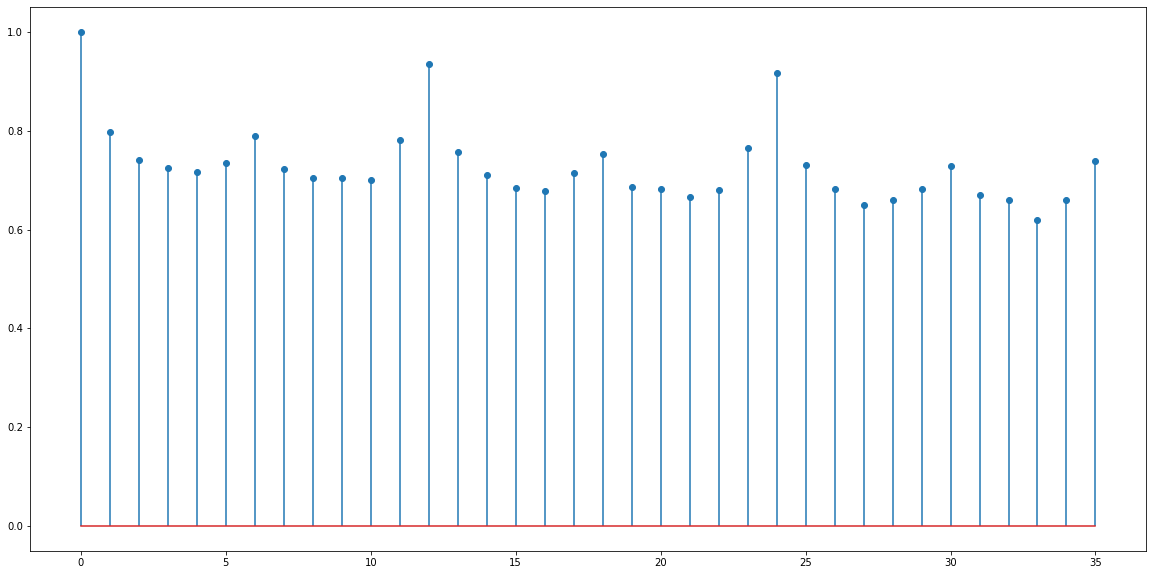

In [136]:
corr=[]
for lag in range(36):
    corr.append(np.corrcoef(mobile_sales.Sales[lag:], mobile_sales.Sales.shift(lag).dropna())[0][1])
plt.stem(np.arange(36),corr)

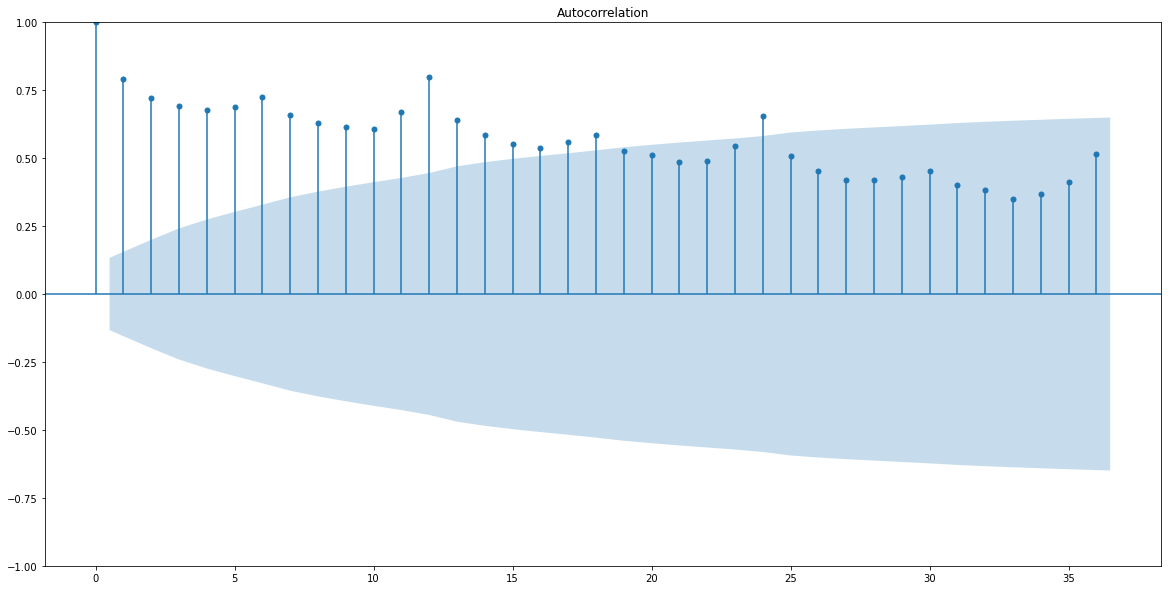

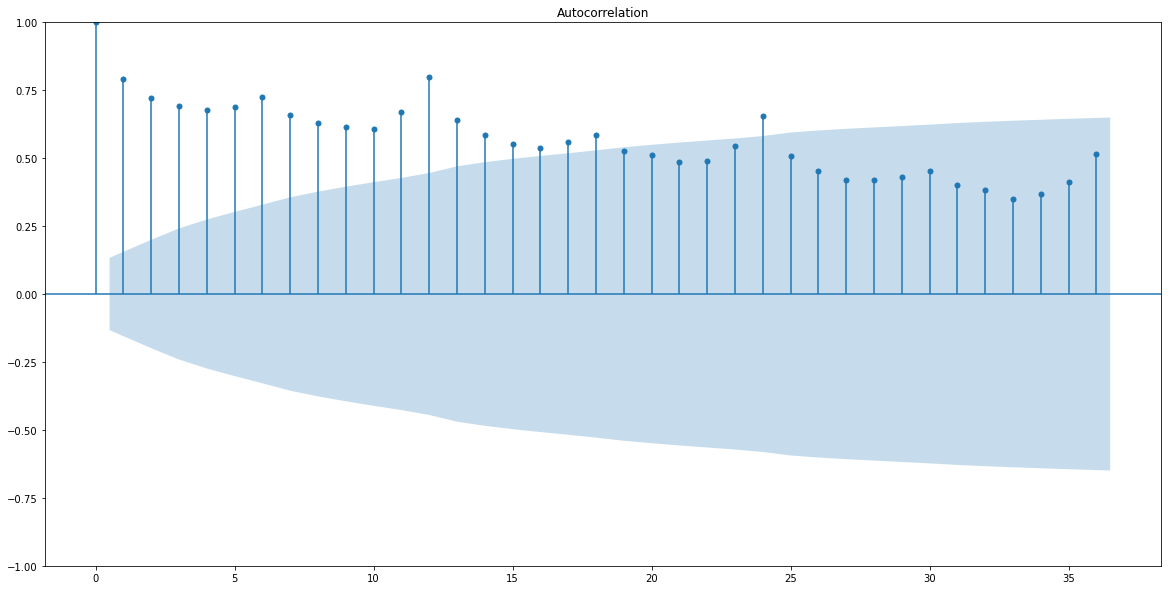

In [137]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(mobile_sales.Sales,lags=36)

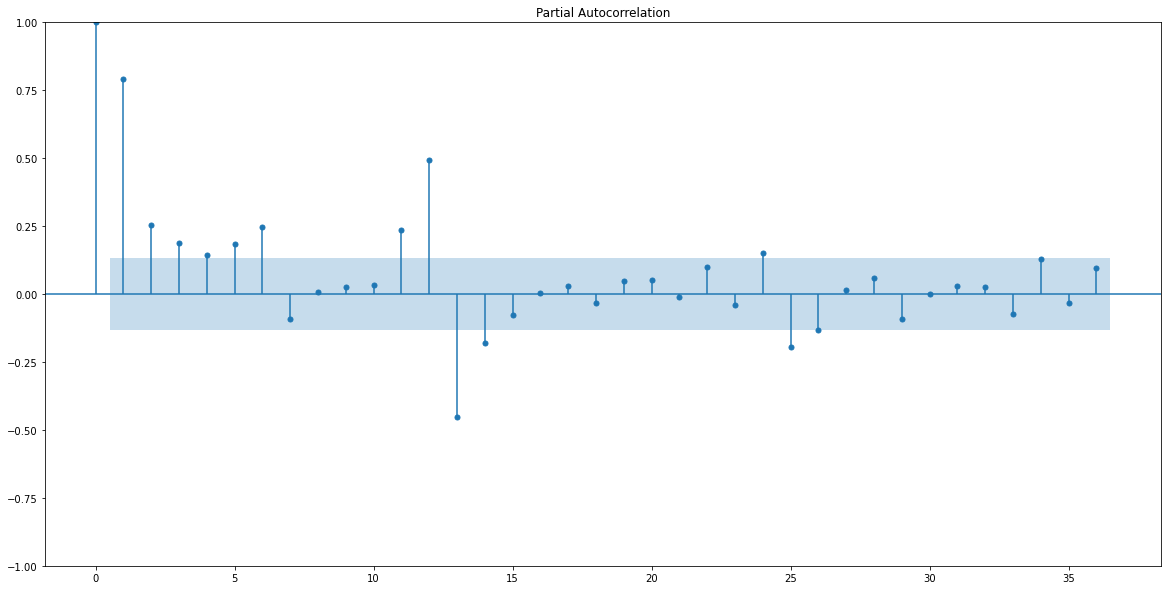

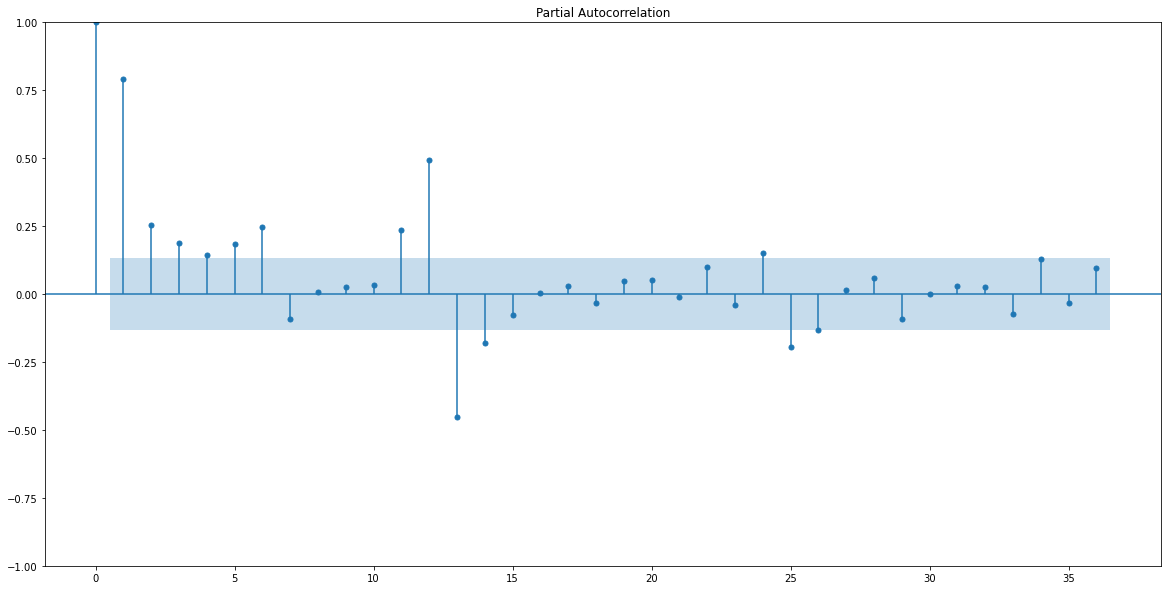

In [138]:
plot_pacf(mobile_sales.Sales,lags=36)

### ARIMA FAMILY OF MODELS

In [139]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [140]:
train_x_st = train_x.copy()
train_x_st.Sales = train_x_st.Sales.diff(1)
train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

Sequence is stationary


### AR(P)

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAE : 798.13
RMSE : 954.83
MAPE: 0.055


/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


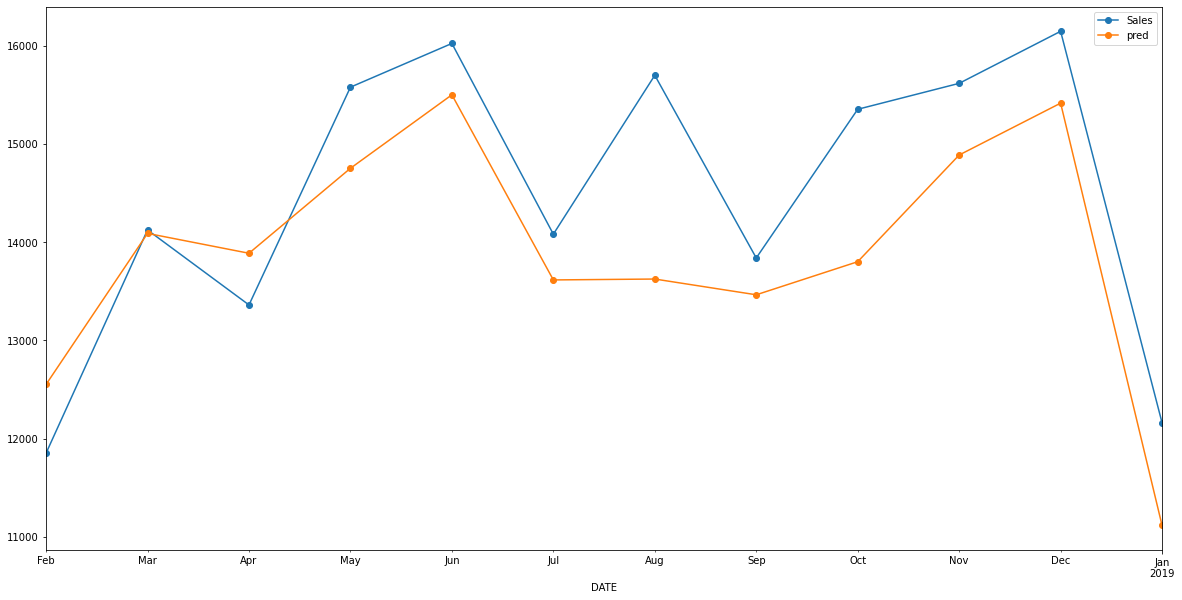

In [141]:
model=SARIMAX(train_x_st.Sales,order=(25,0,0))
model = model.fit(disp=False)         
test_x['pred'] = model.forecast(steps=12)

test_x['pred']=test_x['pred'].cumsum()+train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### MA(q)

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE : 966.116
RMSE : 1060.458
MAPE: 0.067


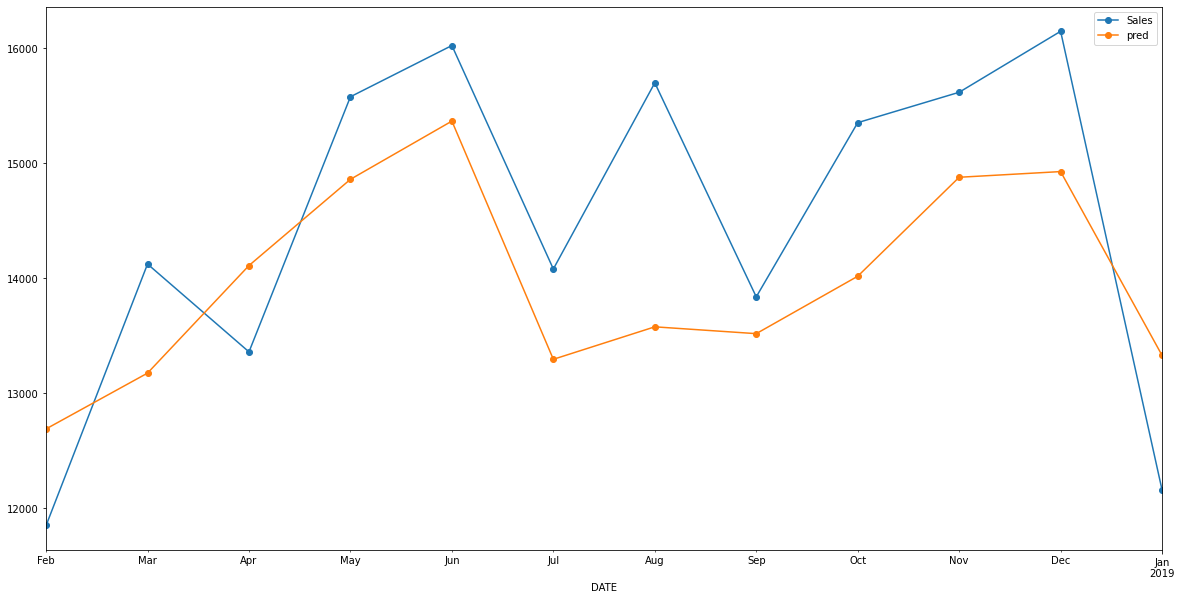

In [142]:
model=SARIMAX(train_x_st.Sales,order=(0,0,23))
model = model.fit(disp=False)         
test_x['pred'] = model.forecast(steps=12)

test_x['pred']=test_x['pred'].cumsum()+train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### ARMA(p,q)

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/

MAE : 585.439
RMSE : 692.927
MAPE: 0.041


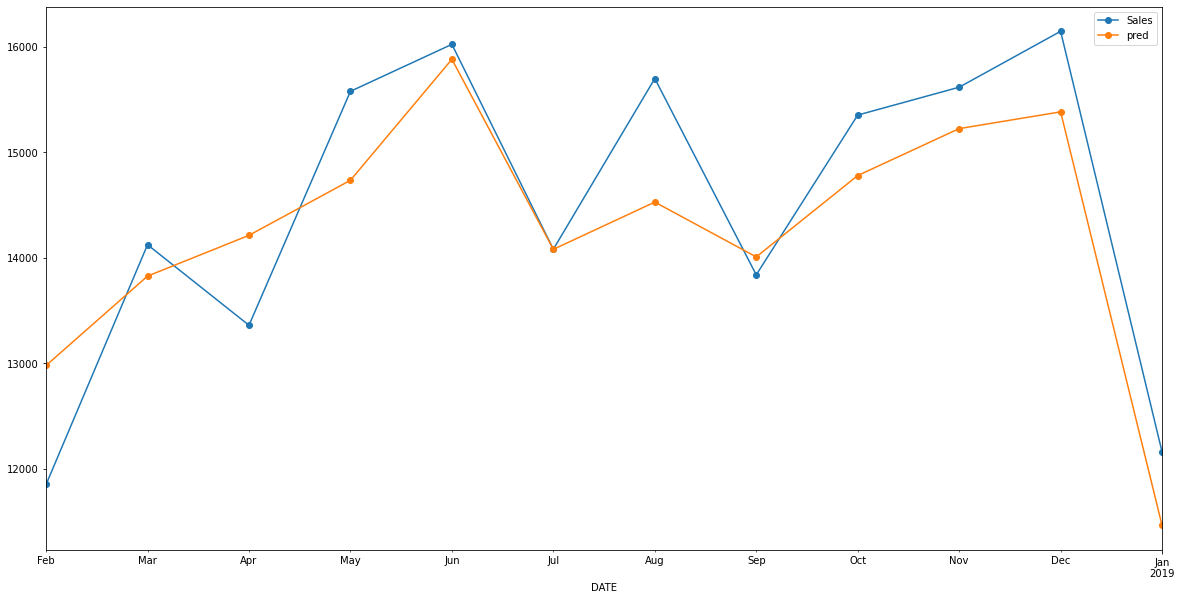

In [143]:
model=SARIMAX(train_x_st.Sales,order=(25,0,23))
model = model.fit(disp=False)         
test_x['pred'] = model.forecast(steps=12)

test_x['pred']=test_x['pred'].cumsum()+train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/

MAE : 585.439
RMSE : 692.927
MAPE: 0.041


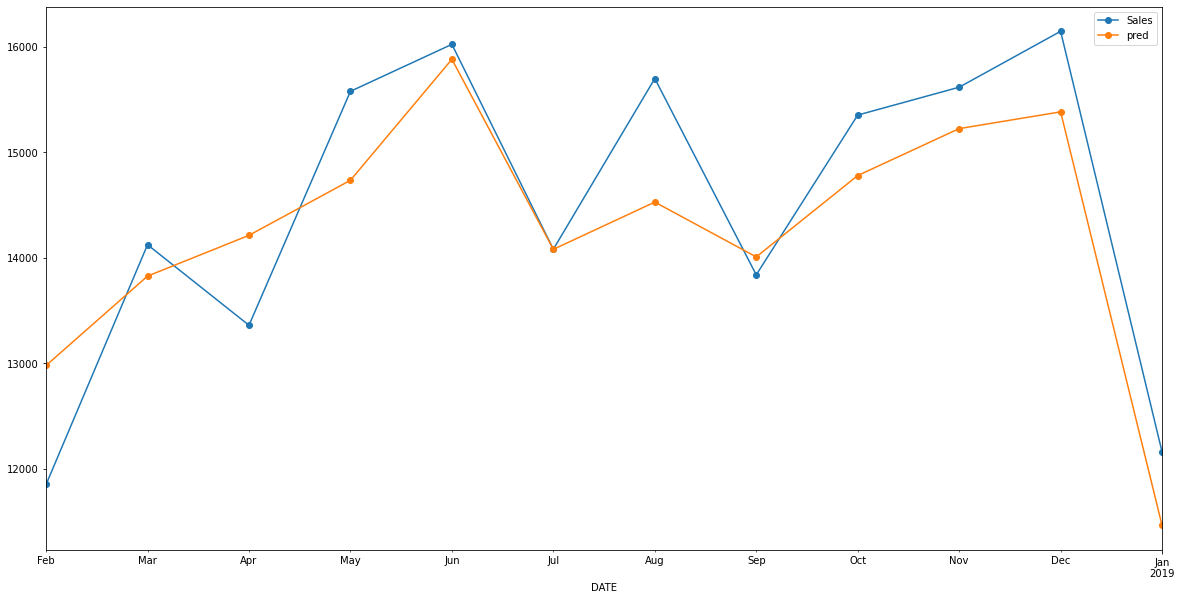

In [144]:
train_x_st = train_x.copy()
train_x_st.Sales = train_x_st.Sales.diff(1)
train_x_st.dropna(inplace=True)
model=SARIMAX(train_x_st.Sales,order=(25,0,23))
model = model.fit(disp=False)         
test_x['pred'] = model.forecast(steps=12)

test_x['pred']=test_x['pred'].cumsum()+train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### ARIMA

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE : 1332.013
RMSE : 1577.753
MAPE: 0.089
CPU times: user 839 ms, sys: 14.7 ms, total: 854 ms
Wall time: 192 ms


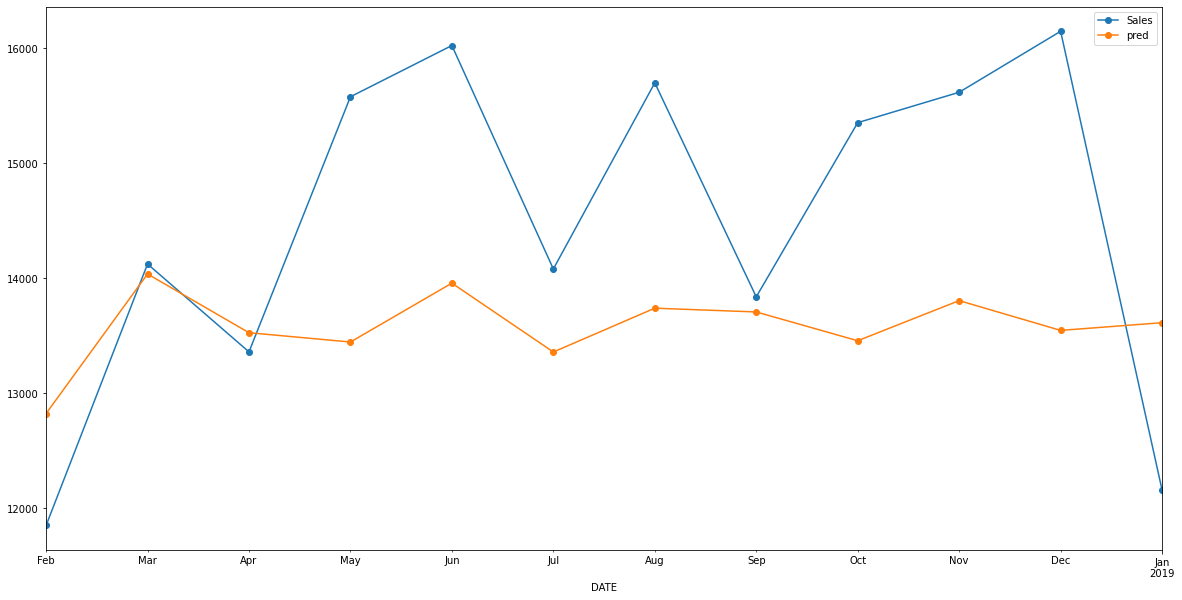

In [145]:
%%time
model=SARIMAX(train_x.Sales,order=(3,1,3))
model = model.fit(disp=False)         
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### SARIMA(p,d,q,P,D,Q,S)

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE : 532.743
RMSE : 620.629
MAPE: 0.037
CPU times: user 10.8 s, sys: 2.09 s, total: 12.9 s
Wall time: 1.77 s


/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


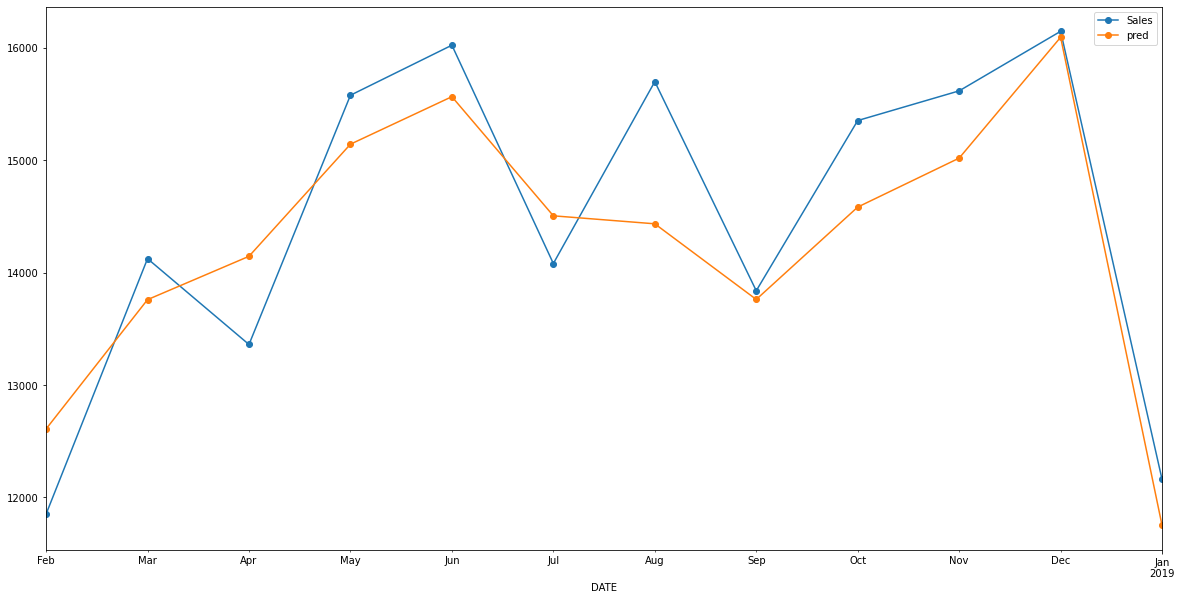

In [146]:
%%time
model=SARIMAX(train_x.Sales,order=(3,1,3),seasonal_order=(1,1,1,12))
model = model.fit(disp=False)         
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

In [147]:
# SARIMAX(train_x.Sales,exog=train_exo_sales,order=(3,1,3),seasonal_order=(1,1,1,12))

### SARIMAX (EXOGENOUS)

In [148]:
df = pd.read_csv('exog.csv')
df.head()

date   weekday  holiday  total
0  1/1/2016    Friday        1  296.0
1  1/2/2016  Saturday        0  191.0
2  1/3/2016    Sunday        0  202.0
3  1/4/2016    Monday        0  105.0
4  1/5/2016   Tuesday        0   98.0

In [149]:
df.shape

(517, 4)

In [150]:
df1=df.copy()


In [151]:
df.isna().sum()

date        0
weekday     0
holiday     0
total      39
dtype: int64

In [152]:
df.dropna(inplace=True)

In [153]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head(5)

weekday  holiday  total
date                                
2016-01-01    Friday        1  296.0
2016-01-02  Saturday        0  191.0
2016-01-03    Sunday        0  202.0
2016-01-04    Monday        0  105.0
2016-01-05   Tuesday        0   98.0

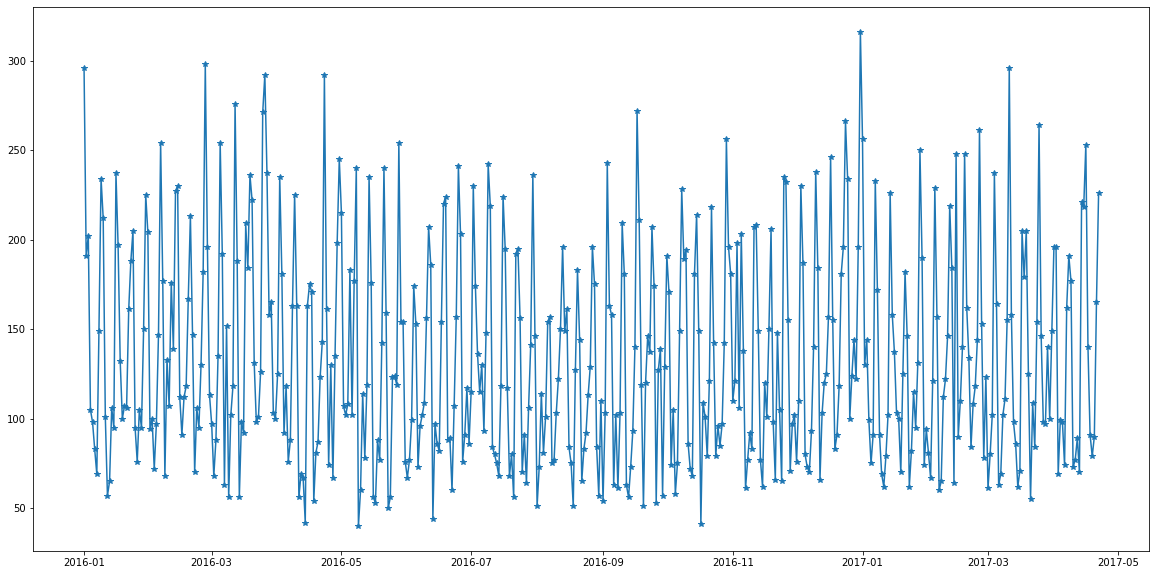

In [154]:
plt.plot(df.index,df['total'], '-*')
plt.show()

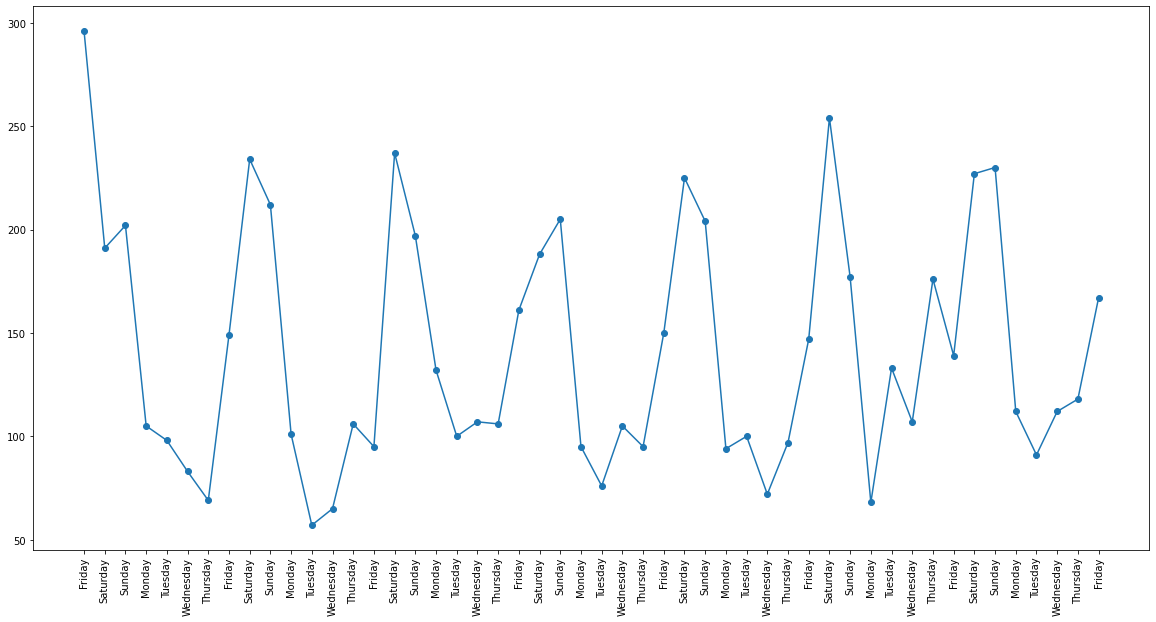

In [155]:
plt.plot(range(50),df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50],rotation = 90)
plt.show()

In [156]:
train = df.iloc[:436]
test = df.iloc[436:]

In [157]:
model = SARIMAX(train['total'], order=(1,0,0), seasonal_order=(1,0,1,7))  # a simple model
results = model.fit(disp=False)
fc = results.forecast(42)

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [158]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end)

MAE : 25.158
RMSE : 31.969
MAPE: 0.202


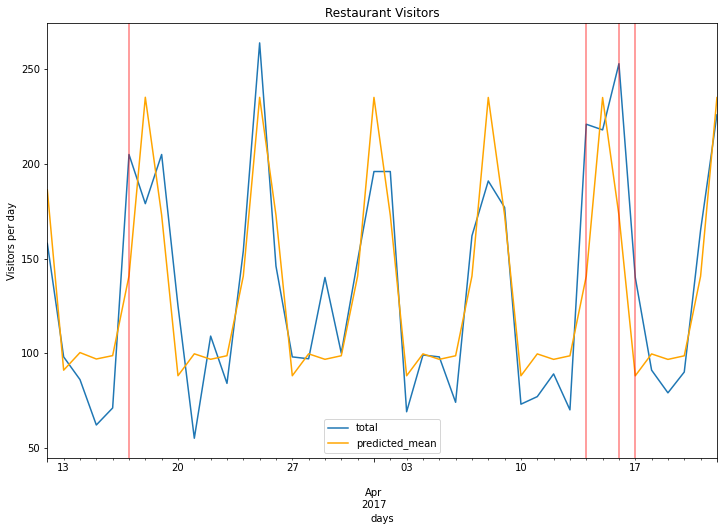

In [159]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'
ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5)

### With EXOG

In [160]:
model = SARIMAX(train['total'], exog=train['holiday'], order=(3,1,3),seasonal_order=(1,0,1,7))
results = model.fit(disp=False)

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [161]:
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

MAE : 18.959
RMSE : 23.242
MAPE: 0.164


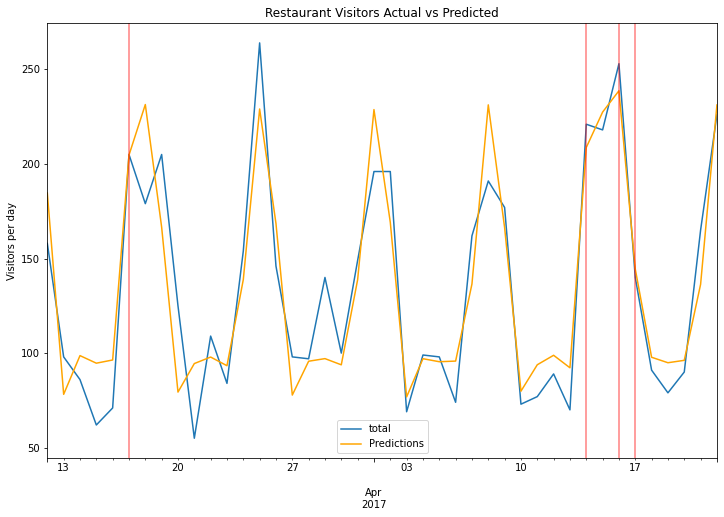

In [162]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

### CONFIDENCE INTERVAL

/var/folders/wc/7x5cjj6171gf3kyxlyncxf_c0000gn/T/ipykernel_98745/2620162445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['lower', 'upper']] = results.get_forecast(steps=42, exog=exog_forecast).conf_int(alpha=0.05).values
/var/folders/wc/7x5cjj6171gf3kyxlyncxf_c0000gn/T/ipykernel_98745/2620162445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['lower', 'upper']] = results.get_forecast(steps=42, exog=exog_forecast).conf_int(alpha=0.05).values
/var/folders/wc/7x5cjj6171gf3kyxlyncxf_c0000

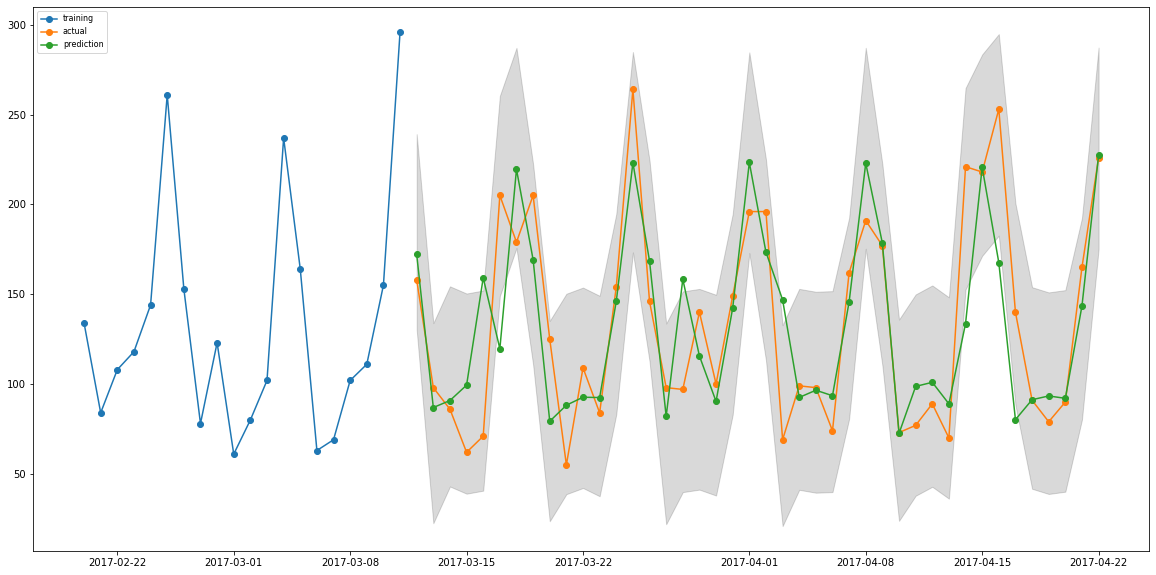

In [163]:
test[['lower', 'upper']] = results.get_forecast(steps=42, exog=exog_forecast).conf_int(alpha=0.05).values
test['pred'] = results.predict(steps=42, exog=exog_forecast).values[-42:]

plt.plot(train['total'][-20:], '-o', label='training')
plt.plot(test['total'], '-o', label='actual')
plt.plot(test['pred'], '-o', label='prediction')
plt.fill_between(test.index, test['lower'], test['upper'], color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Prophet

In [164]:

from prophet import Prophet

df=df1.copy()

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [165]:
## Required
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total']
df = df[['ds', 'y', 'holiday']]
df.head()

ds      y  holiday
0 2016-01-01  296.0        1
1 2016-01-02  191.0        0
2 2016-01-03  202.0        0
3 2016-01-04  105.0        0
4 2016-01-05   98.0        0

In [166]:
m = Prophet()
m.fit(df[['ds', 'y']][:-39])
future = m.make_future_dataframe(periods=39, freq="D")
forecast = m.predict(future)
forecast.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appen

Initial log joint probability = -50.0756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       852.818    0.00236155       98.0754           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       852.866   3.14326e-08        69.647      0.1894           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-01-01  143.021597  116.242533  197.523974   143.021597   143.021597   
1 2016-01-02  142.949814  195.689207  278.436310   142.949814   142.949814   
2 2016-01-03  142.878030  149.404299  231.742903   142.878030   142.878030   
3 2016-01-04  142.806246   58.067889  141.797949   142.806246   142.806246   
4 2016-01-05  142.734463   60.473987  144.797214   142.734463   142.734463   

   additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
0       15.210069             15.210069             15.210069  15.210069   
1       94.486471             94.486471             94.486471  94.486471   
2       46.764581             46.764581             46.764581  46.764581   
3      -42.864620            -42.864620            -42.864620 -42.864620   
4      -39.700778            -39.700778            -39.700778 -39.700778   

   weekly_lower  weekly_upper  multiplicative_terms  \
0     15.210069     15.210069                   0.0   
1     94.486471     94.486471                   0.0   
2     46.764581     46.764581                   0.0   
3    -42.864620    -42.864620                   0.0   
4    -39.700778    -39.700778                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  158.231666  
1                         0.0                         0.0  237.436285  
2                         0.0                         0.0  189.642611  
3                         0.0                         0.0   99.941627  
4                         0.0                         0.0  103.033685

In [167]:
performance(df['y'][:-39],forecast['yhat'][:-39])

MAE : 24.056
RMSE : 31.988
MAPE: 0.213


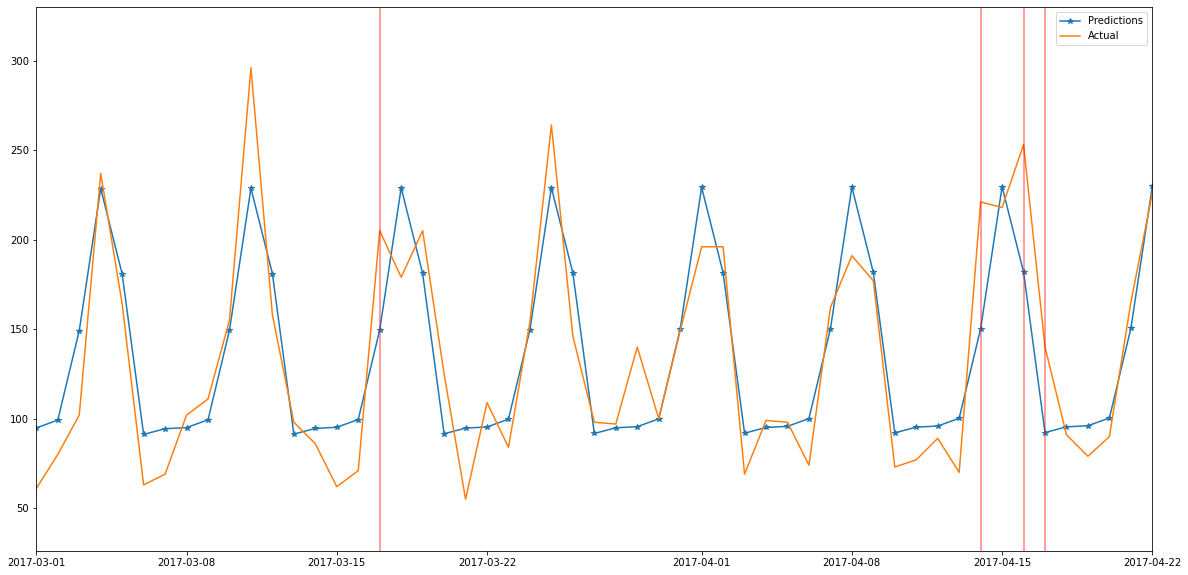

In [168]:
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']: 
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-03-01'), pd.to_datetime('2017-04-22'))
plt.legend()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/prophet/forecaster.py:8

Initial log joint probability = -50.0756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        958.77      0.004027        96.846           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       959.083   6.57355e-05       89.6605   5.811e-07       0.001      222  LS failed, Hessian reset 
     199       959.087   7.67341e-07       73.4156      0.5608      0.3445      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       959.296    0.00114553       126.475   8.588e-06       0.001      361  LS failed, Hessian reset 
     268        959.45   9.33301e-05       109.487   8.988e-07       0.001      450  LS failed, Hessian reset 
     299       959.472    1.9293e-07       98.8653      0.7668      0.7668      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

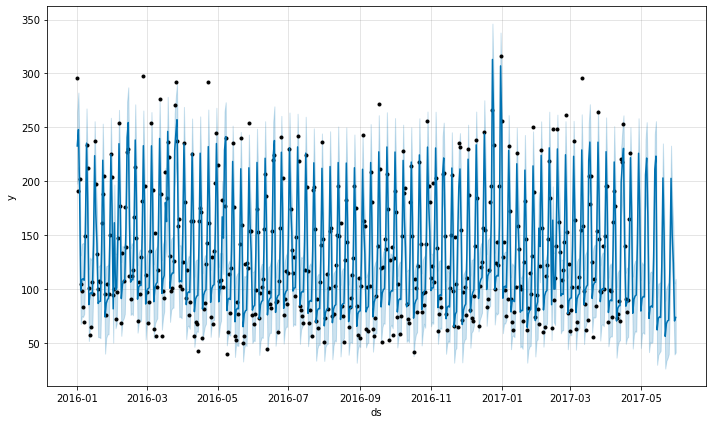

In [169]:
model2=Prophet(yearly_seasonality=True, weekly_seasonality=True,
model2.add_regressor('holiday') #adding holidays data in the model3
model2.fit(df[:-39])
forecast2 = model2.predict(df)
fig = model2.plot(forecast2)

In [170]:
performance(df['y'][:-39],forecast2['yhat'][:-39])

MAE : 19.99
RMSE : 25.75
MAPE: 0.181


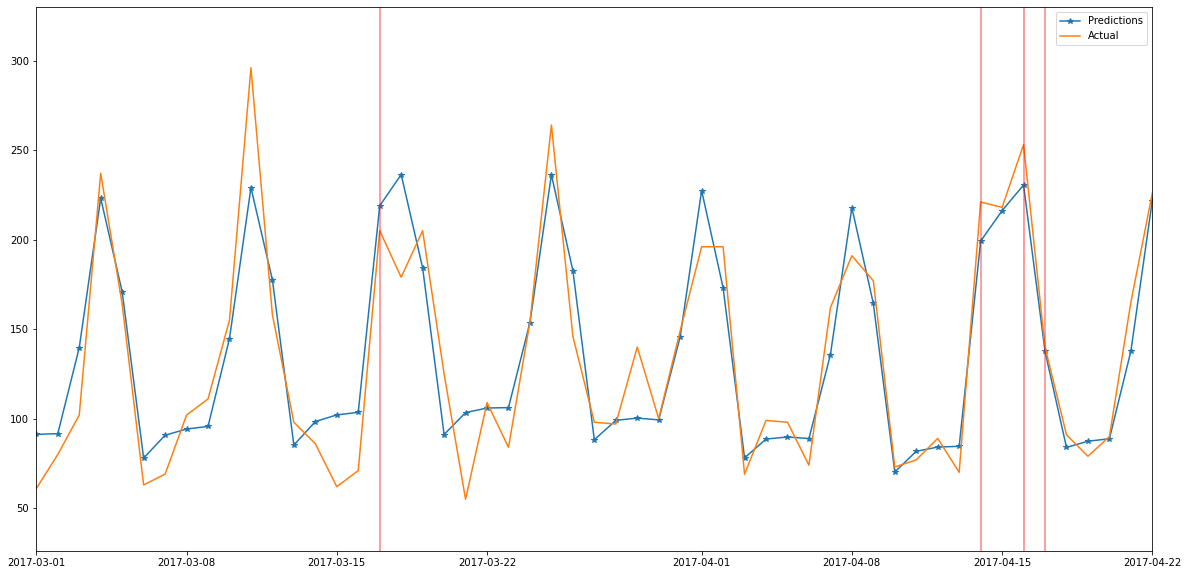

In [171]:
plt.plot(forecast2['ds'], forecast2['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']: 
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-03-01'), pd.to_datetime('2017-04-22'))
plt.legend()

In [172]:
def plot_changepoints(signal, changepoints):
    for cp in changepoints:
        plt.axvline(x=cp, color='#FA8072')
    plt.plot(signal, '-*', label='signal')

    start = 0
    trends = np.array([])
    for i in changepoints:
        x = np.arange(start, i)
        y = signal[start:i]
        l1 = np.polyfit(x, y, deg=1)
        trend = x*l1[0] + l1[1]
        trends = np.append(trends, trend)
        start = i

    plt.plot(trends, label='trend')
    plt.legend()
    plt.show()

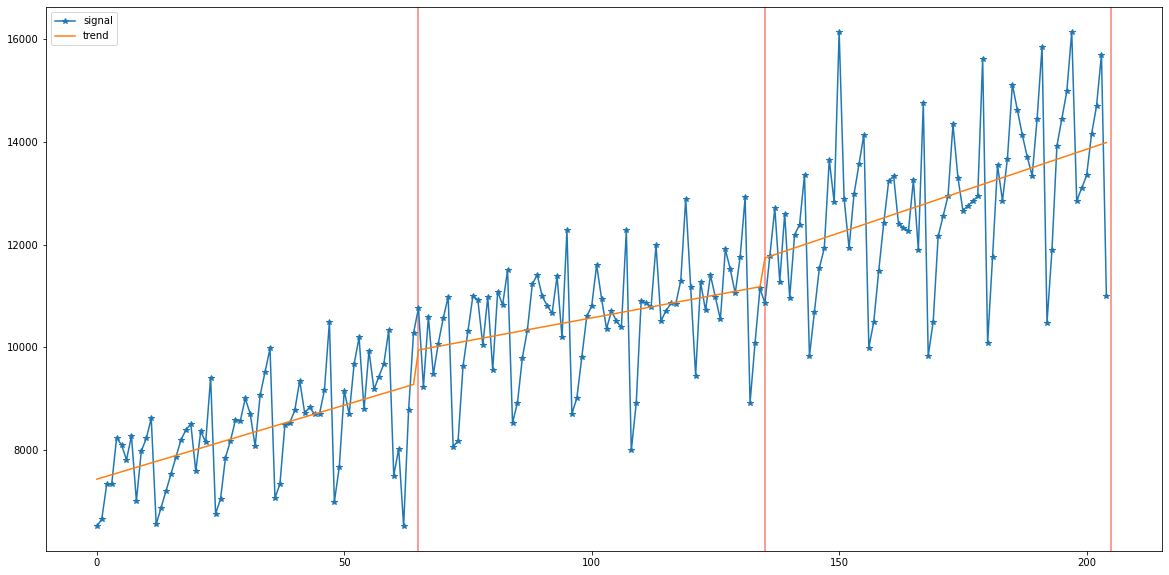

In [183]:
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal = train_x.Sales.values
# signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
changepoints = algo.predict(pen=5)


plot_changepoints(signal, changepoints)

In [174]:
### Change Point Calculation

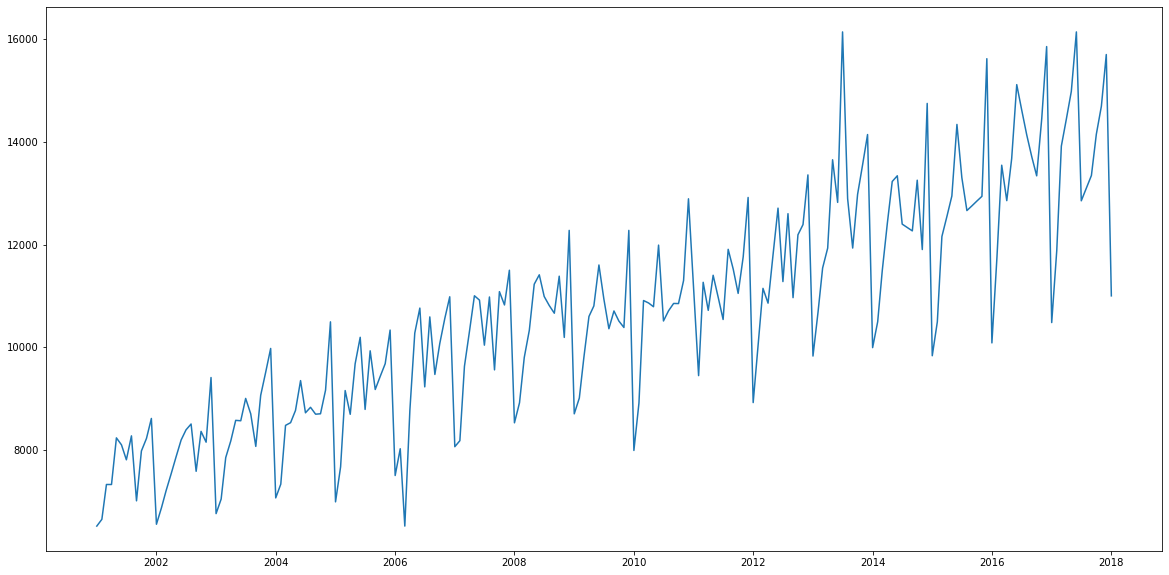

In [175]:
signal = train_x.Sales
plt.plot(signal)

In [176]:
np.polyfit(np.arange(len(signal)), signal, deg=1)

array([  32.06114313, 7381.64242482])

In [181]:
signal = train_x.Sales
window = 60   # already experimented with
def get_slope(y):
    return np.polyfit(np.arange(len(y)), y, deg=1)[0]

changepoints = signal.loc[
    abs(signal.rolling(window, center=True).apply(get_slope).diff()) > 7.5
].index
temp = signal.reset_index()
changepoints = temp.loc[temp['DATE'].isin(changepoints)].index.tolist()



def plot_changepoints(signal, changepoints):
    for cp in changepoints:
        plt.axvline(x=cp, color='#FA8072')
    plt.plot(signal, '-*', label='signal')

    start = 0
    trends = np.array([])
    for i in changepoints:
        x = np.arange(start, i)
        y = signal[start:i]
        l1 = np.polyfit(x, y, deg=1)
        trend = x*l1[0] + l1[1]
        trends = np.append(trends, trend)
        start = i

    plt.plot(trends, label='trend')
    plt.legend()
    plt.show()

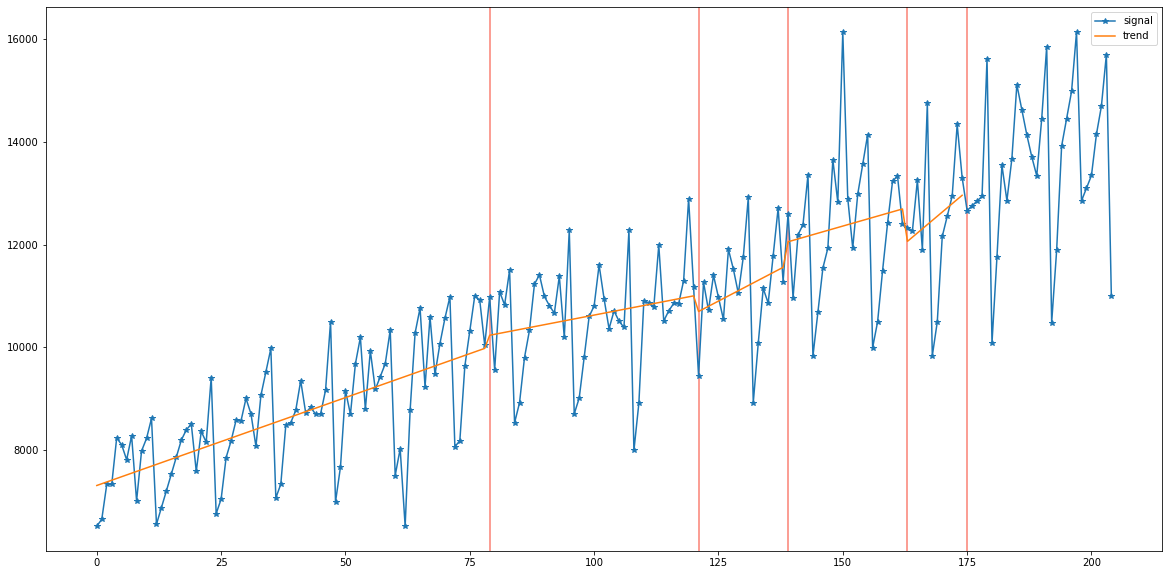

In [182]:
plot_changepoints(signal.values, changepoints)

### Regression as a MOdel

In [188]:
df1

date    weekday  holiday  total
0     1/1/2016     Friday        1  296.0
1     1/2/2016   Saturday        0  191.0
2     1/3/2016     Sunday        0  202.0
3     1/4/2016     Monday        0  105.0
4     1/5/2016    Tuesday        0   98.0
..         ...        ...      ...    ...
512  5/27/2017   Saturday        0    NaN
513  5/28/2017     Sunday        0    NaN
514  5/29/2017     Monday        1    NaN
515  5/30/2017    Tuesday        0    NaN
516  5/31/2017  Wednesday        0    NaN

[517 rows x 4 columns]

In [186]:
df=df1.copy()
df['date'] = pd.to_datetime(df['date'])


In [187]:
df["weekday"] = np.where(((df["weekday"] == "Friday") | (df["weekday"] == "Thursday") | (df["weekday"] == "Wednesday") | (df["weekday"] == "Tuesday") | (df["weekday"] == "Monday")), "working_day", "weekend")
intmdt = pd.get_dummies(df['weekday'])
df = pd.concat([df, intmdt],axis =1 )
df.head()

date      weekday  holiday  total  weekend  working_day
0 2016-01-01  working_day        1  296.0        0            1
1 2016-01-02      weekend        0  191.0        1            0
2 2016-01-03      weekend        0  202.0        1            0
3 2016-01-04  working_day        0  105.0        0            1
4 2016-01-05  working_day        0   98.0        0            1

In [189]:
for i in range(1,32):
    df["Lag_{}".format(i)] = df['total'].shift(i)

In [191]:
lis = ['Lag_{}'.format(i) for i in range(1,32)]
df.dropna(inplace = True)    # Drop because some Lags will be NaN.
df['last_month_avg_level'] = df.loc[:,lis].sum(axis=1)/31
lis = ['Lag_{}'.format(i) for i in range(1,8)]
df['last_week_avg_level'] = df.loc[:,lis].sum(axis=1)/7
lis = ["Lag_{}".format(i) for i in range(1,15)]
df['last_2week_avg_level'] = df.loc[:,lis].sum(axis = 1)/14
df['dayofweek'] = df['date'].dt.dayofweek
df['sale_wrt_dow'] = df.groupby('dayofweek')['total'].transform('mean')
df[['sale_wrt_dow', 'dayofweek']].drop_duplicates()
df.head(3)


date      weekday  holiday  total  weekend  working_day  Lag_1  \
31 2016-02-01  working_day        0   94.0        0            1  204.0   
32 2016-02-02  working_day        1  100.0        0            1   94.0   
33 2016-02-03  working_day        0   72.0        0            1  100.0   

    Lag_2  Lag_3  Lag_4  ...  Lag_27  Lag_28  Lag_29  Lag_30  Lag_31  \
31  225.0  150.0   95.0  ...    98.0   105.0   202.0   191.0   296.0   
32  204.0  225.0  150.0  ...    83.0    98.0   105.0   202.0   191.0   
33   94.0  204.0  225.0  ...    69.0    83.0    98.0   105.0   202.0   

    last_month_avg_level  last_week_avg_level  last_2week_avg_level  \
31            143.419355           135.714286            139.214286   
32            136.903226           135.571429            136.500000   
33            133.967742           139.000000            136.500000   

    dayofweek  sale_wrt_dow  
31          0      89.59375  
32          1      94.53125  
33          2      94.68750  

[3 rows x 42 columns]

In [192]:
import copy             #dfo has the data with all the columns
dfo = df.copy()
df = dfo.copy()
df = df[['total', 'Lag_1', 'last_month_avg_level', 'last_week_avg_level', 
          'last_2week_avg_level', 'sale_wrt_dow', 'holiday']] 
df.head()

total  Lag_1  last_month_avg_level  last_week_avg_level  \
31   94.0  204.0            143.419355           135.714286   
32  100.0   94.0            136.903226           135.571429   
33   72.0  100.0            133.967742           139.000000   
34   97.0   72.0            129.774194           134.285714   
35  147.0   97.0            129.516129           134.571429   

    last_2week_avg_level  sale_wrt_dow  holiday  
31            139.214286     89.593750        0  
32            136.500000     94.531250        1  
33            136.500000     94.687500        0  
34            134.000000     99.015625        0  
35            133.357143    147.171875        0

In [193]:
train = df.iloc[:df.shape[0]-42].dropna()
test = df.iloc[df.shape[0]-42:]

train_X = train.drop(["total"],axis =1)
train_y = train['total']
test_X = test.drop(["total"],axis =1)
test_y = test['total']

In [194]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape

# Train and pred
model = LinearRegression()
model.fit(train_X, train_y)
y_pred = pd.Series(model.predict(test_X), index=test.index)
mape(test['total'],y_pred)

0.15509506491480668

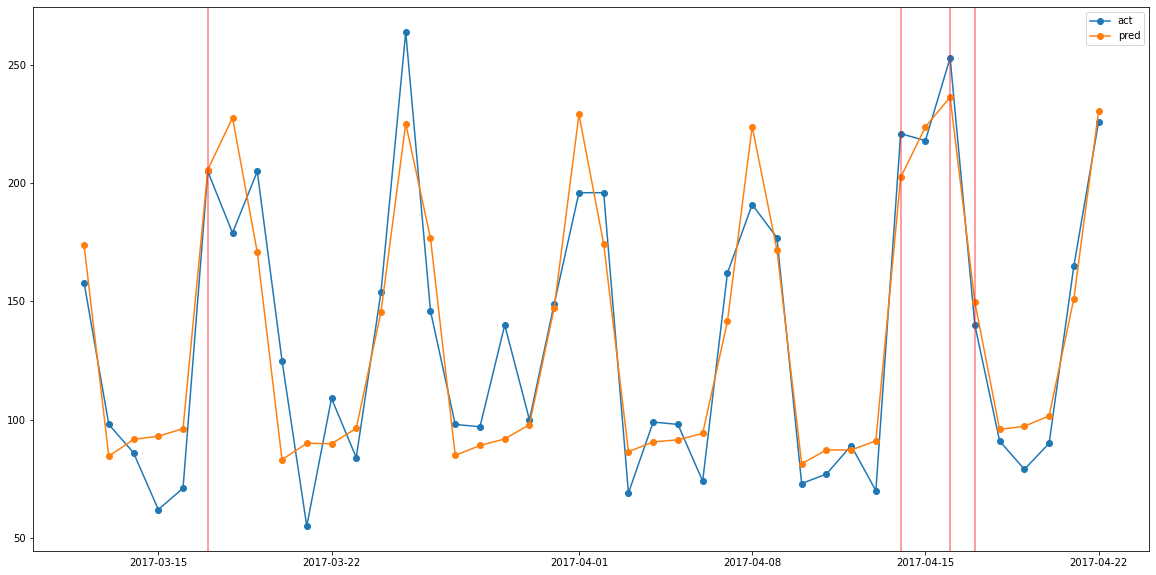

In [195]:
plt.plot(dfo.tail(42)['date'], test_y, '-o', label='act')
plt.plot(dfo.tail(42)['date'], y_pred, '-o', label='pred')
for x in dfo[-42:].query('holiday==1')['date']: 
    plt.axvline(x=x, color='red', alpha = 0.5)
plt.legend()

In [199]:
model=sm.tsa.seasonal_decompose(mobile_sales.Sales,model='additive')

### ACF /PACF Advanced

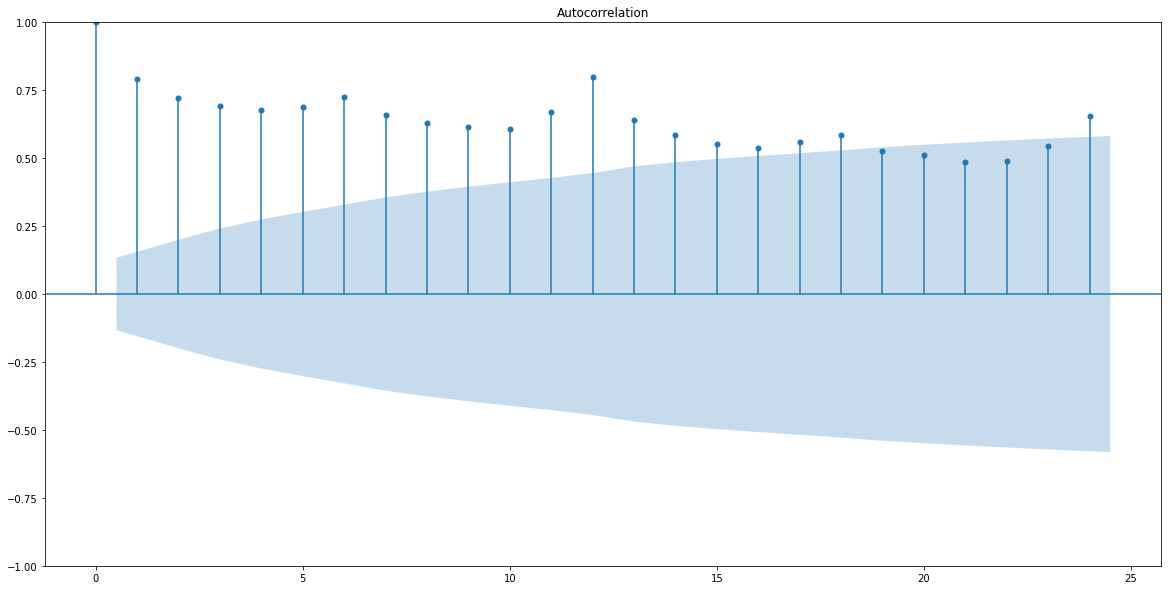

In [196]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(mobile_sales.Sales);

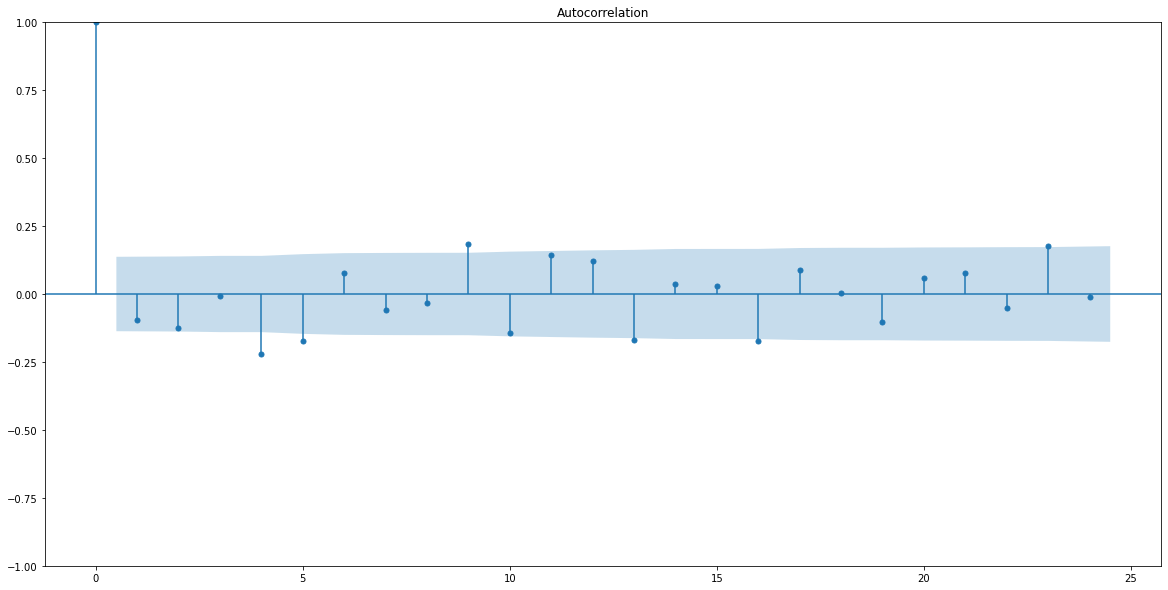

In [205]:
plot_acf(model.resid.dropna());

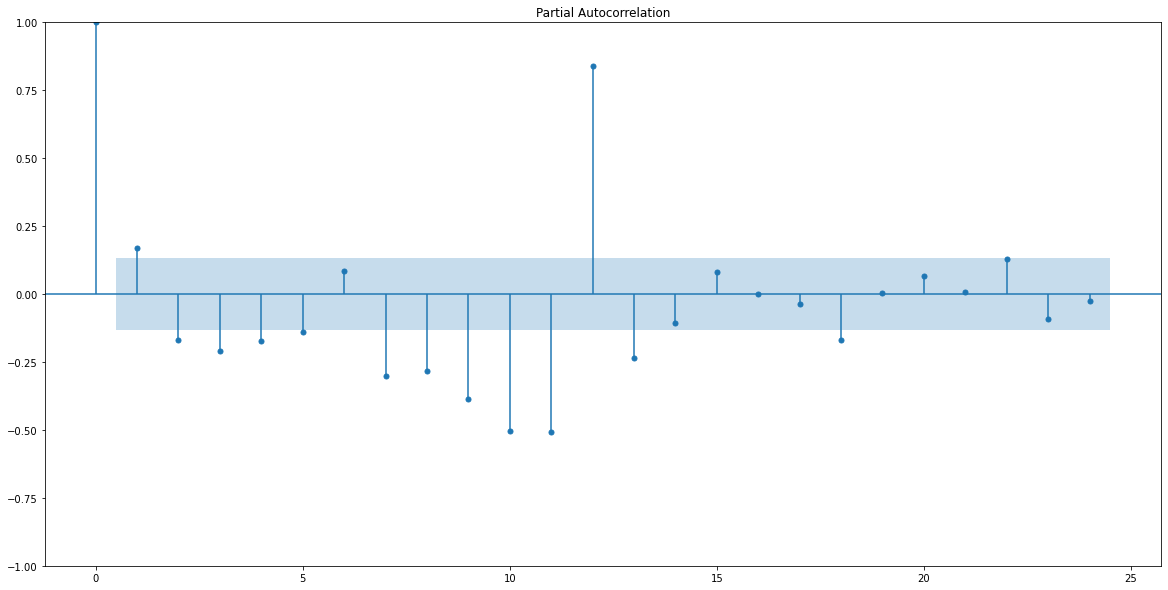

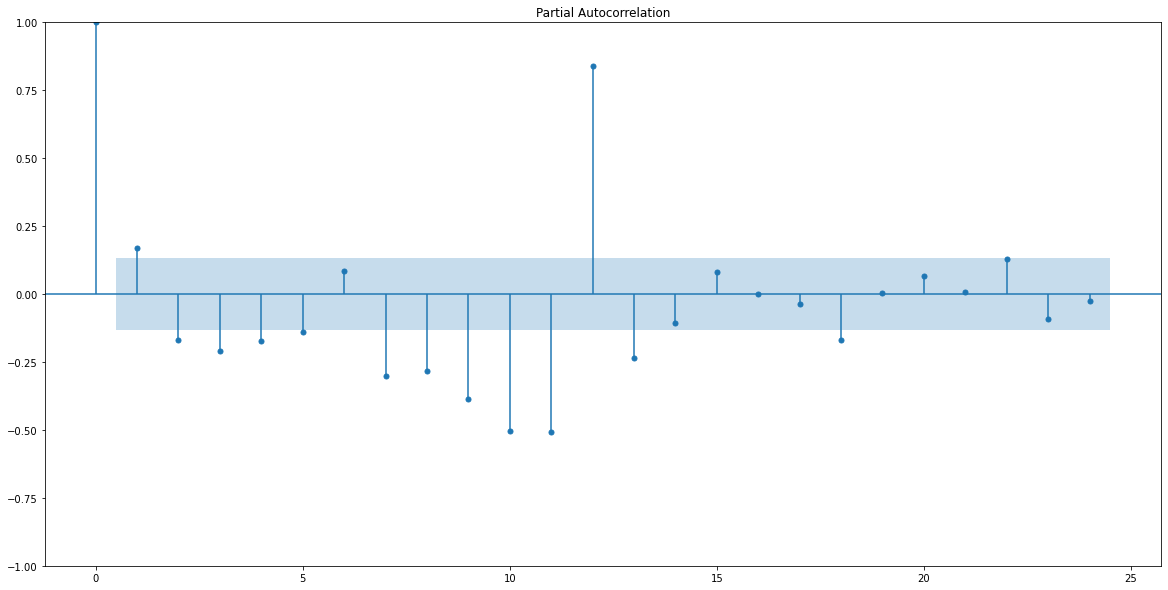

In [209]:
plot_pacf(model.seasonal.dropna())

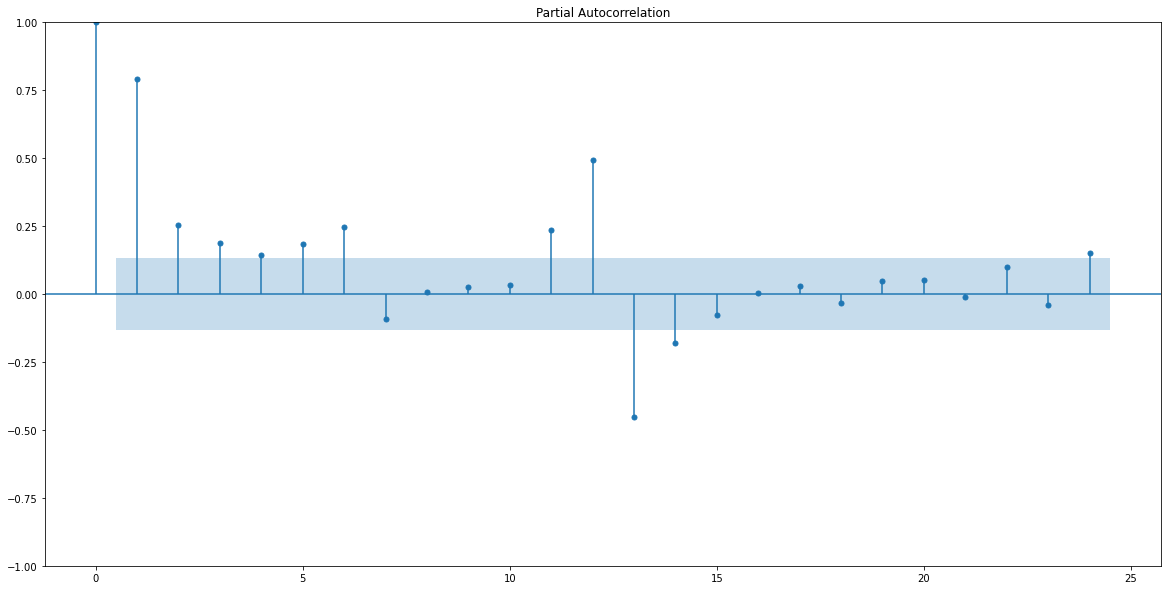

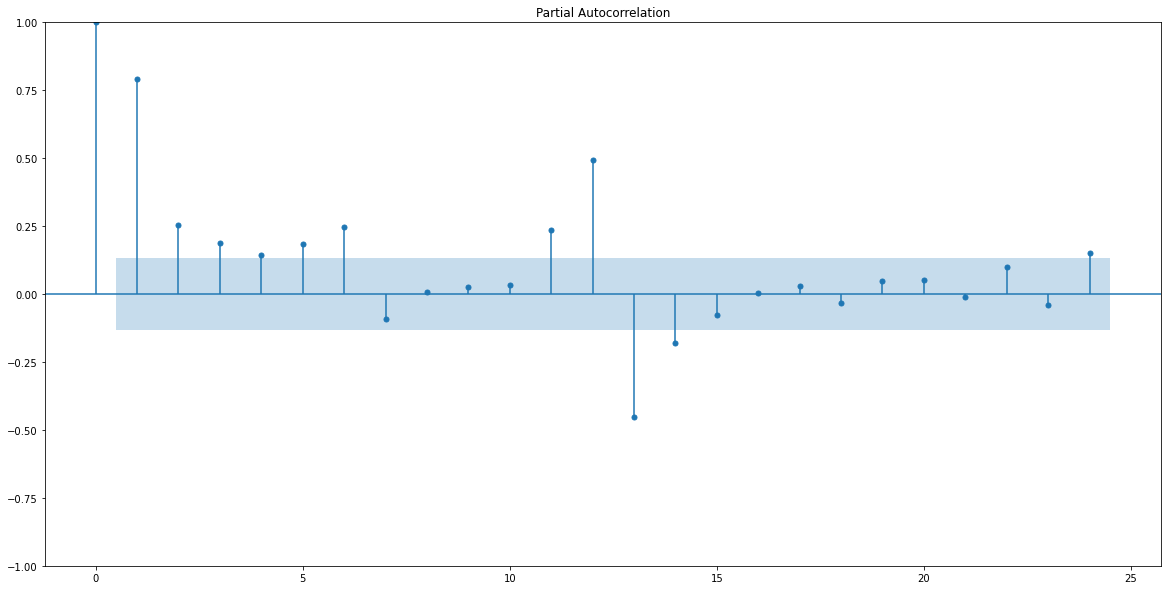

In [207]:
plot_pacf(mobile_sales.Sales)